# Forest Cover Type Prediction
#### Chris, Dylan, Krista, I-Ching, Riley

In [99]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

# show all columns in DF
pd.set_option('display.max_columns', None)

## Introduction

In this notebook, we will explore data obtained from the US Geological Survey and USFS for 30x30 areas.  This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. Using this data, we are to best predict the type of cover that these forests provide, broken into 7 categories: spruce/fir, lodgepole pine, ponderosa pine, cottonwood/willow, aspen, douglas-fir, and krummholz.  

In [100]:
df = pd.read_csv('../data/train.csv', header=0)
df.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6279                 1                 0   
1                                6225                 1                 0   
2                                6121                 1                 0   
3                                6211                 1                 0   
4                                6172                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0            1  

In [101]:
target_names = ['1 - Spruce/Fir', '2 - Lodgepole Pine', '3 - Ponderosa Pine', 
                '4 - Cottonwood/Willow', '5 - Aspen', '6 - Douglas-fir',
                '7 - Krummholz']

The first step in dealing with this data will be to clean up the raw data.

In [102]:
# Drop the ID and last column (Cover Type)
data = df.drop(['Id', df.columns[len(df.columns) - 1]], axis=1)
data.shape

(15120, 54)

In [103]:
# Store the cover type in labels
labels = df[df.columns[len(df.columns) - 1]]
labels.shape

(15120L,)

In [104]:
for column in data.columns:
    print(data[column].describe(), "\n")

(count    15120.000000
mean      2749.322553
std        417.678187
min       1863.000000
25%       2376.000000
50%       2752.000000
75%       3104.000000
max       3849.000000
Name: Elevation, dtype: float64, '\n')
(count    15120.000000
mean       156.676653
std        110.085801
min          0.000000
25%         65.000000
50%        126.000000
75%        261.000000
max        360.000000
Name: Aspect, dtype: float64, '\n')
(count    15120.000000
mean        16.501587
std          8.453927
min          0.000000
25%         10.000000
50%         15.000000
75%         22.000000
max         52.000000
Name: Slope, dtype: float64, '\n')
(count    15120.000000
mean       227.195701
std        210.075296
min          0.000000
25%         67.000000
50%        180.000000
75%        330.000000
max       1343.000000
Name: Horizontal_Distance_To_Hydrology, dtype: float64, '\n')
(count    15120.000000
mean        51.076521
std         61.239406
min       -146.000000
25%          5.000000
50%      

In [105]:
data.groupby(df[df.columns[len(df.columns) - 1]]).size()

# all cover types have an equal number of data points

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

## Helper Functions

In [106]:
def split_data(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.33, random_state=42)
    return X_train, y_train, X_test, y_test

# plot two columns
def my_scatter(col_1, col_2, figsize=(8, 6)):
    fig = plt.figure(figsize=figsize)
    plt.scatter(col_1, col_2, c=labels.values,
                s=50, alpha=.5, cmap='viridis')
    plt.xlabel(col_1.name)
    plt.ylabel(col_2.name)

## Exploratory Data Analysis

Let's take a look at the data that we have.

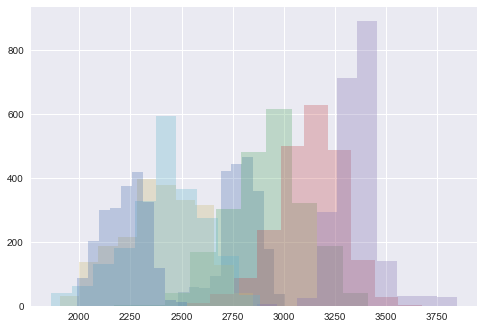

In [10]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for label in labels.unique():
    plt.hist(data.Elevation[labels==label], **kwargs)

Elevation seems to be one of the more binnable for the cover type.  We made a note to focus on this variable.

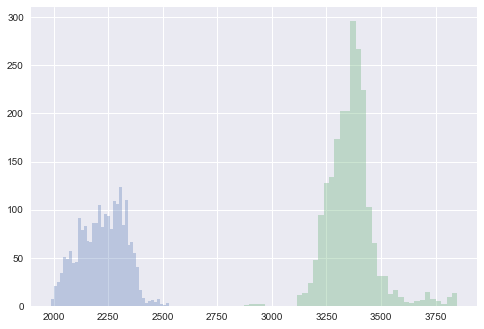

In [11]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)

plt.hist(data.Elevation[labels==4], **kwargs)
plt.hist(data.Elevation[labels==7], **kwargs);

Types 4 and 7 are nicely separated.

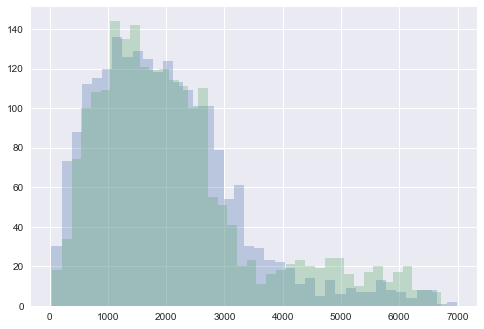

In [12]:
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==1], **kwargs)
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==2], **kwargs);

Types 1 and 2 have a lot of overlap on elevation. This could make them harder to predict.

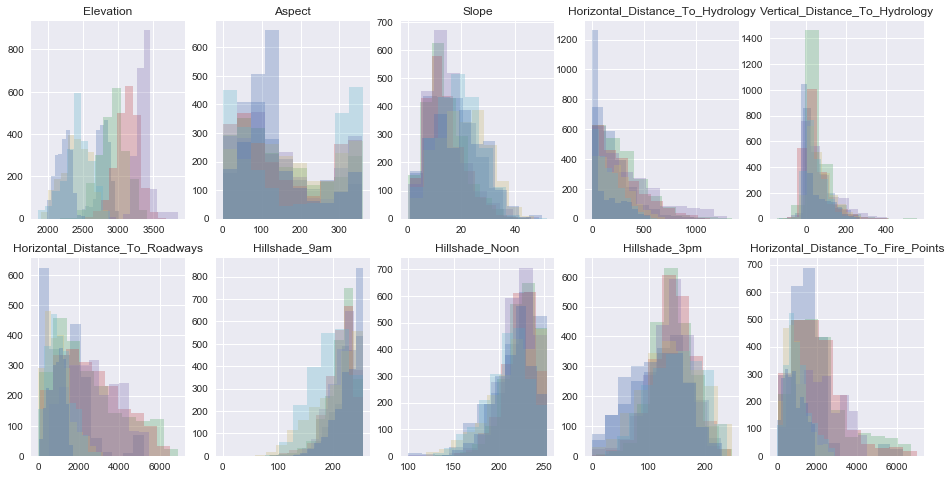

In [13]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in labels.unique():
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

From this, we can see that elevation has the most amount of variability between the different cover types.  Many of the other variables seem to overlap quite a lot for the different cover types, which indicates that they will not be very helpful in differentiating the different cover type.  The other notable features are the Horizontal and Veritcal distances to the disturbances, which have a bit more variation.  

In [14]:
my_columns = [x for x in data.columns.tolist() if "Soil_Type" not in x]
my_columns = [x for x in my_columns if "Wilderness" not in x]
df1 = data.reindex(columns=my_columns)

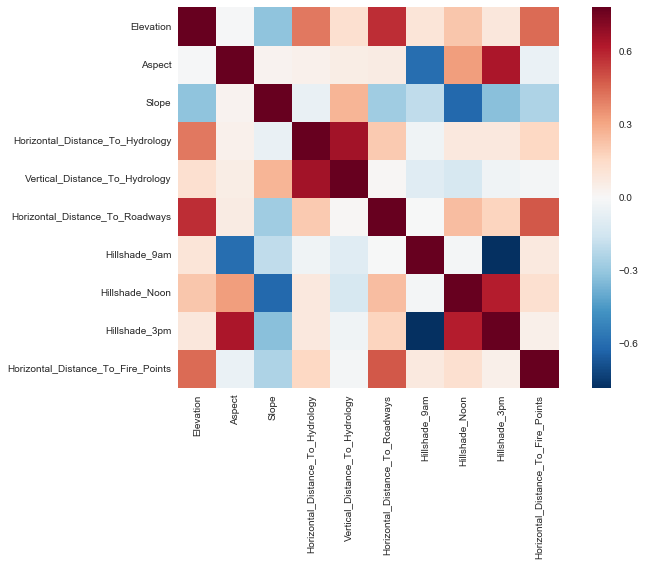

In [15]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corrmat, vmax=.5, square=True);

From this, we can see several things. First, the vertical and horizonal distances are pretty strongly correlated.  Second, the HIllshade_3pm is positively correlated with Hillsahde_noon, and negatively correlated with Hillshade_9am.  We can also see that there is a positive correlation with aspect as well.

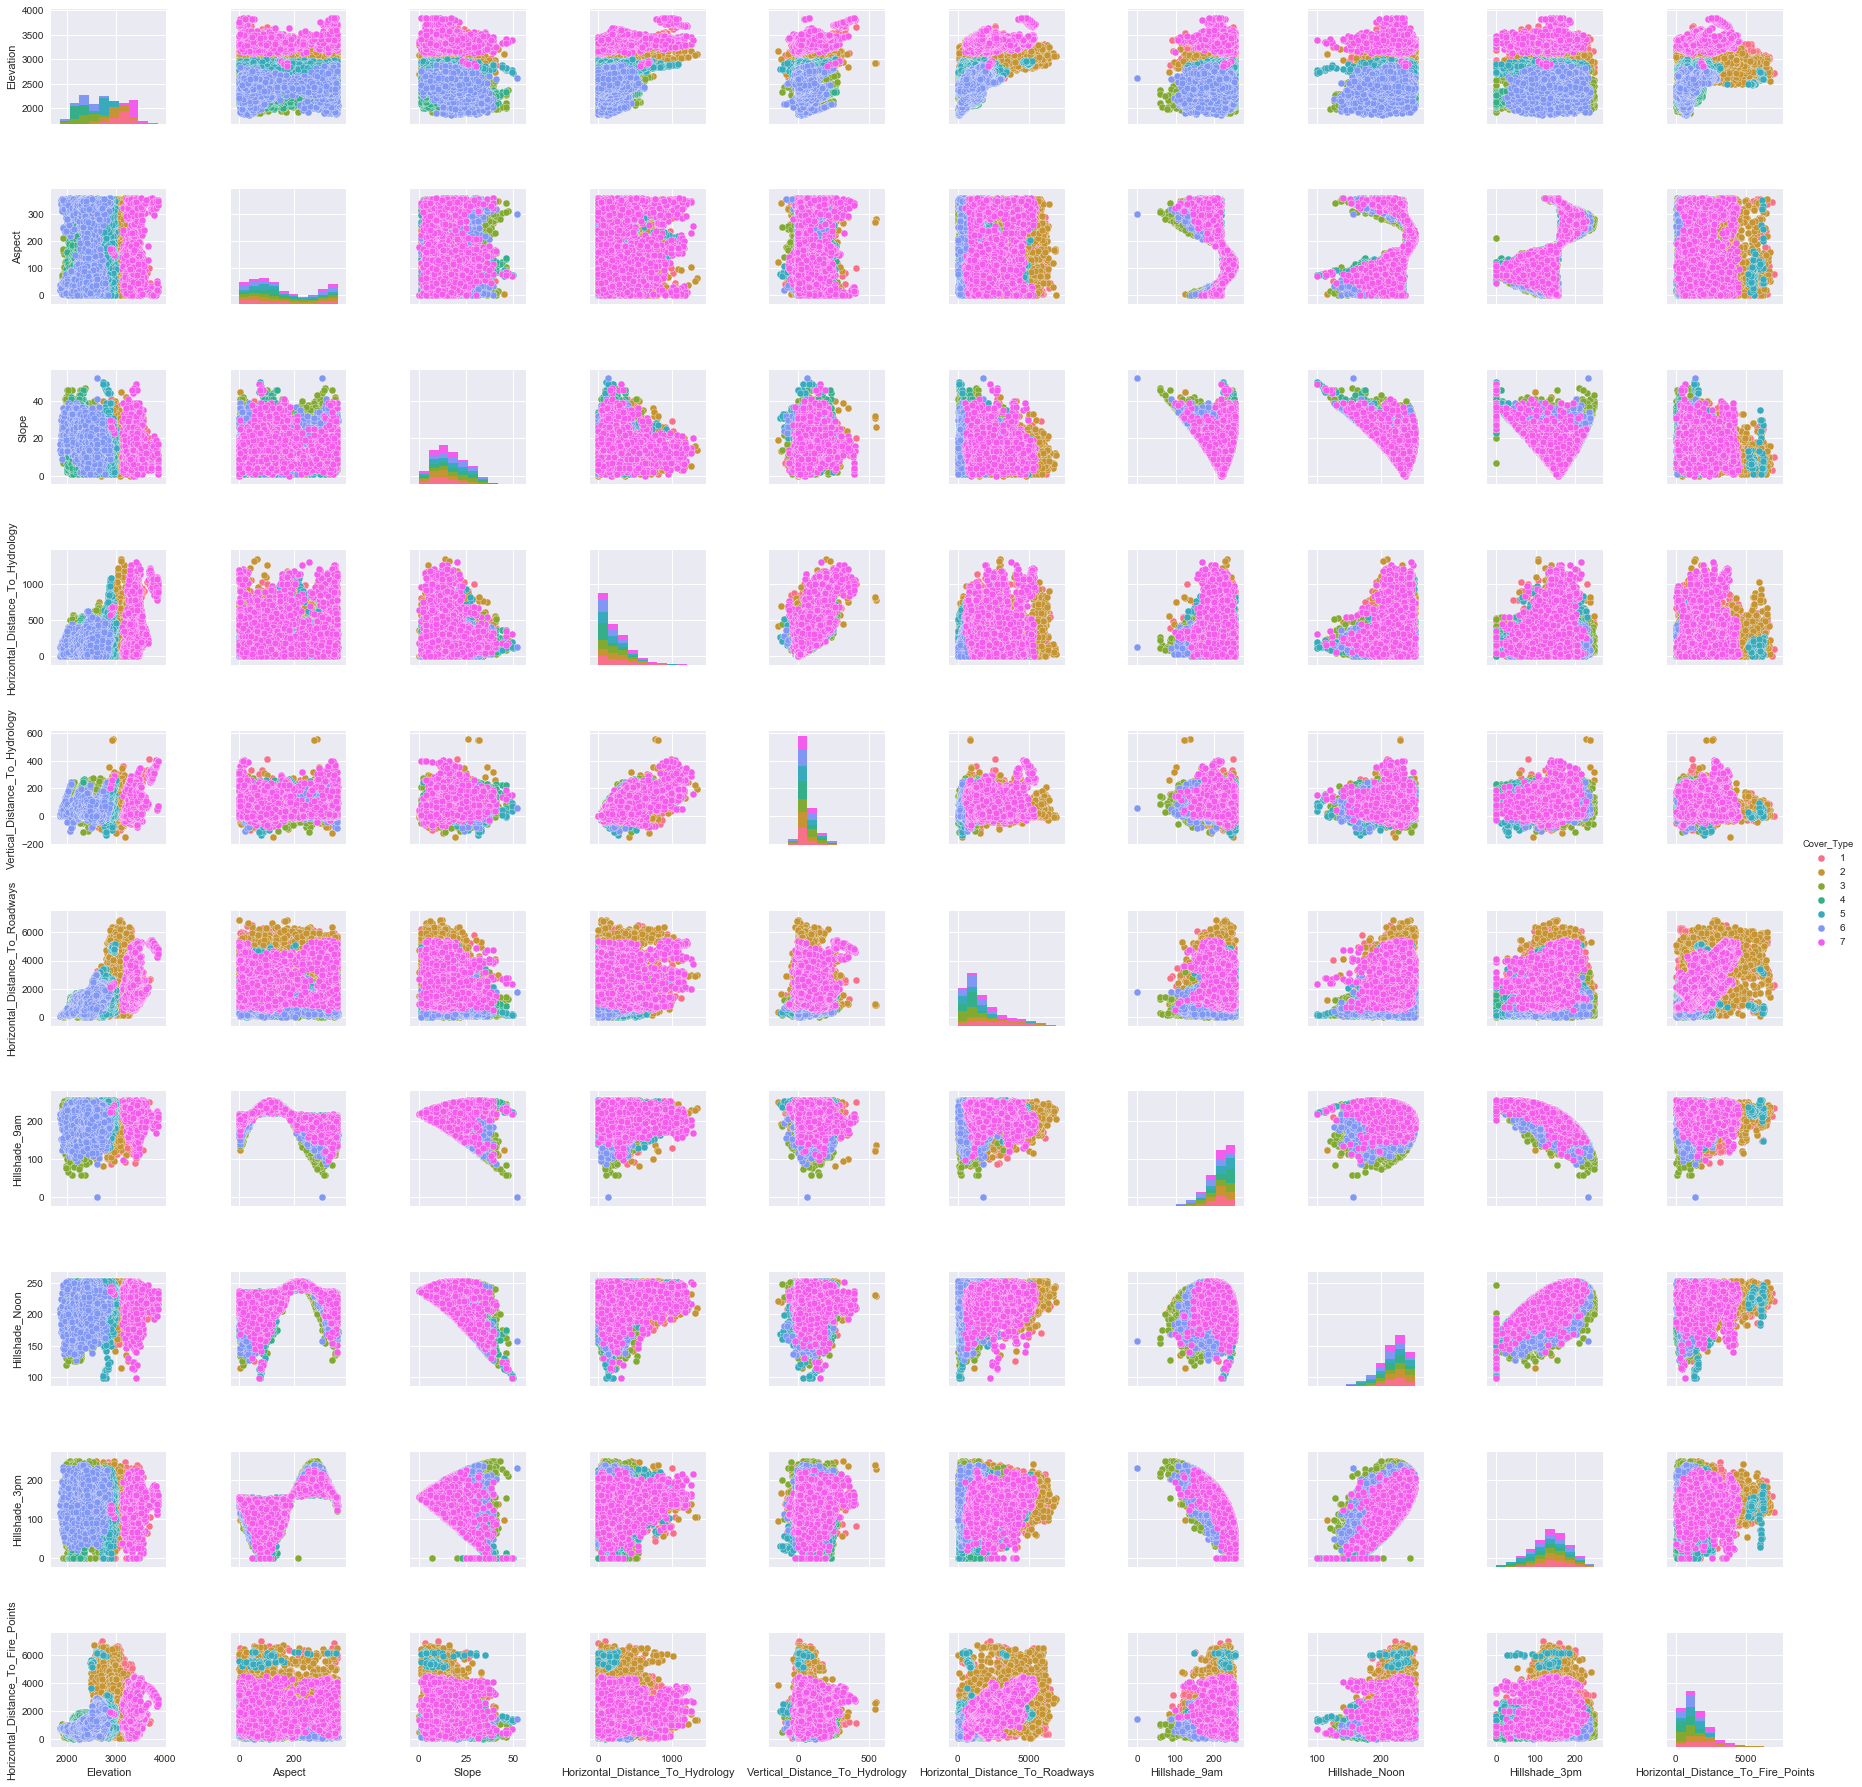

In [16]:
g = sns.pairplot(df, vars=my_columns, hue="Cover_Type")

In [17]:
# Count different soil types
data.loc[:, 'Soil_Type1':'Soil_Type40'].sum(axis=1).describe()

count    15120.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

In [18]:
col_names = df.columns.tolist()
A = np.array(col_names)
soil_types = [item for item in A if "Soil" in item]
for soil_type in soil_types:
    print (soil_type, df[soil_type].sum())

Soil_Type1 355
Soil_Type2 623
Soil_Type3 962
Soil_Type4 843
Soil_Type5 165
Soil_Type6 650
Soil_Type7 0
Soil_Type8 1
Soil_Type9 10
Soil_Type10 2142
Soil_Type11 406
Soil_Type12 227
Soil_Type13 476
Soil_Type14 169
Soil_Type15 0
Soil_Type16 114
Soil_Type17 612
Soil_Type18 60
Soil_Type19 46
Soil_Type20 139
Soil_Type21 16
Soil_Type22 345
Soil_Type23 757
Soil_Type24 257
Soil_Type25 1
Soil_Type26 54
Soil_Type27 15
Soil_Type28 9
Soil_Type29 1291
Soil_Type30 725
Soil_Type31 332
Soil_Type32 690
Soil_Type33 616
Soil_Type34 22
Soil_Type35 102
Soil_Type36 10
Soil_Type37 34
Soil_Type38 728
Soil_Type39 657
Soil_Type40 459


Soil types don't seem to be very consisten, and some soil types have 0 data points, which may need to be dropped.  Overall, we may find that the soil type won't be too helpful.

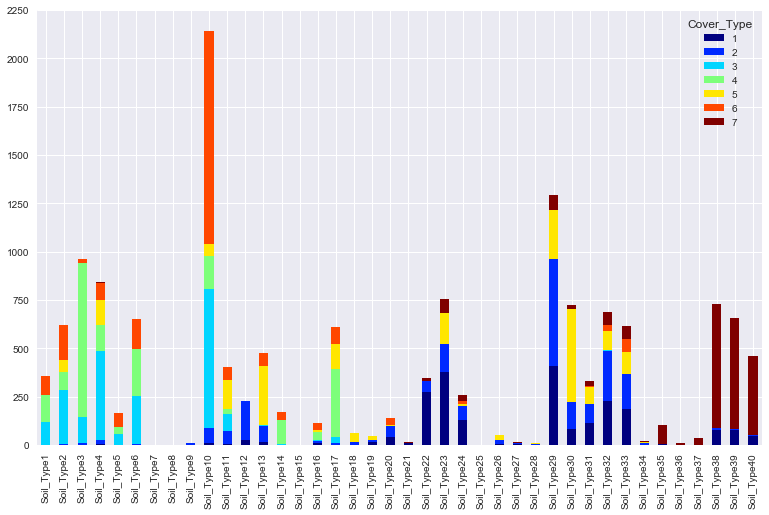

In [19]:
types_sum = df[soil_types].groupby(df['Cover_Type']).sum()
types_sum.T.plot(kind='bar', stacked=True, figsize=(13,8), cmap='jet')

We can see some subtle differences when plotting the cover type that different soils have.  For example, cover type 7 seems to be heavily on the soil types 38,39,40.  In addition, cover type 6 seems to trend towards the lower soil types.  Other points seem to be a bit more scattered.

In [20]:
# Count at different wilderness areass
data.loc[:, 'Wilderness_Area1':'Wilderness_Area4'].sum(axis=1).describe()

count    15120.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

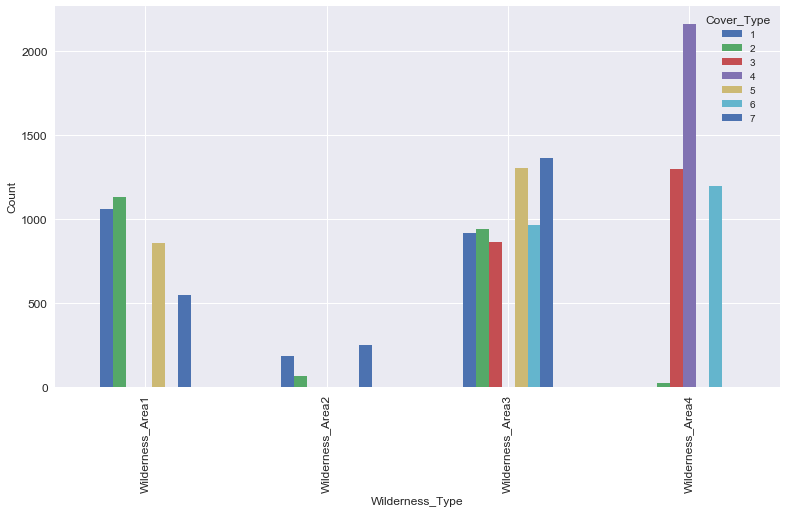

In [21]:
col_names_wilderness = [x for x in df.columns.tolist() if "Wilderness" in x]
types_sum = df[col_names_wilderness].groupby(df['Cover_Type']).sum()
ax = types_sum.T.plot(kind='bar', figsize=(13, 7), legend=True, fontsize=12)
ax.set_xlabel("Wilderness_Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

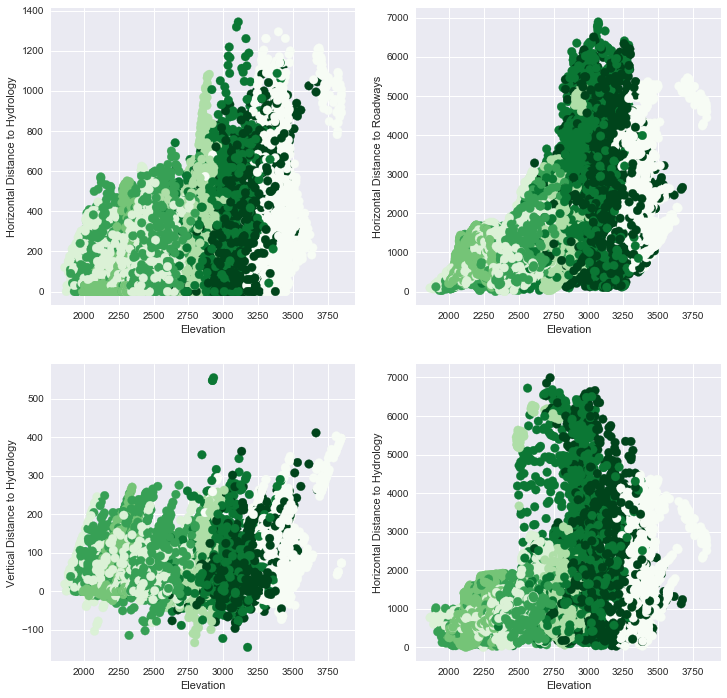

In [22]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology") 

plt.show()

Looking at this, we can see with a small adjustment to the elevation values in relation to the horizontal distance to hydrology, we can get the labels differentiated better.  We try to do this in the next figure.

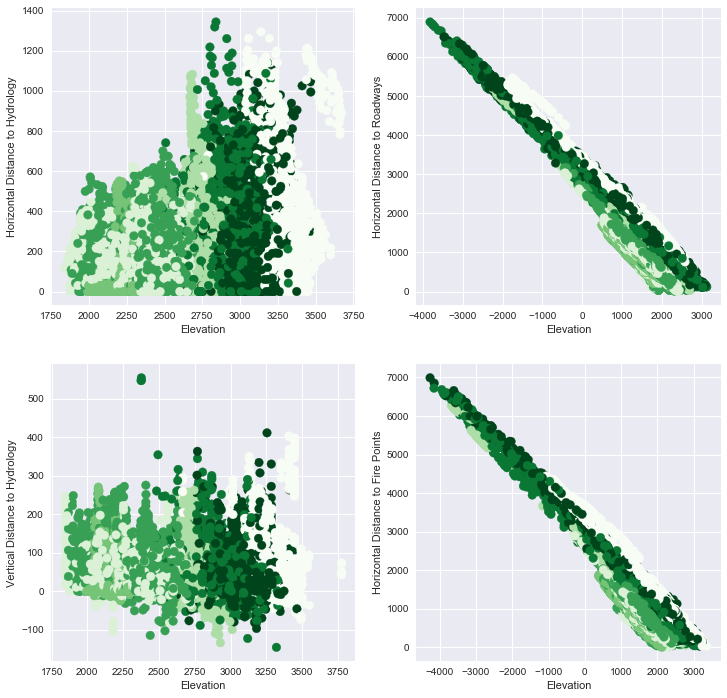

In [155]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation - .2 *df.Horizontal_Distance_To_Hydrology, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Roadways, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation - df.Vertical_Distance_To_Hydrology, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Fire_Points, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Fire Points") 

plt.show()

We can see that the cover types cluster a bit better.  We can see if adjusting this will help with the model.

# Dimensionality Reduction

We'd  like to reduce our feature space to make our modelling simpler, while hopefully preserving the variablility/information in our data.

Below we explore how much variance is explained as we increase the number of PCA components. We found that there was not a logical cut off that allowed us to both reduce the number of features, and preserve variance within the data.

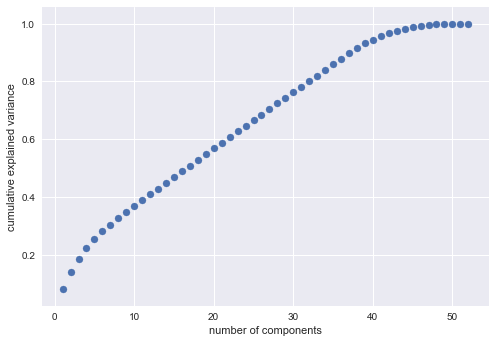

In [24]:
X_train, y_train, X_test, y_test = split_data(data, labels)

X_train_std = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=52)
pca.fit(X_train_std)
plt.scatter(range(1,53),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We'd also like to see if on an extremely simplified case with only 2 PCA components if we could pick find visibly separable data.

In [25]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train_std)

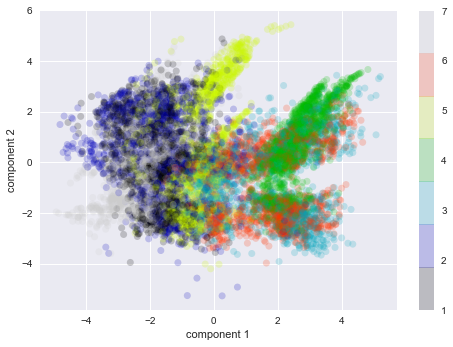

In [26]:
plt.scatter(X_2D[:, 0], X_2D[:, 1],
            c=y_train, edgecolor='none', alpha=0.2,
            cmap=plt.cm.get_cmap('nipy_spectral', 7))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

After additional attempts, we didn't find strong evidence that PCA was going to help us much. See the the appendix at the end of this notebook for additional trials with PCA

# Feature Selection

In [107]:
# baseline
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

lr_accuracy = np.mean(y_pred == y_test)
lr_accuracy

0.67715430861723447

## Forward selection with Logistic Regression

In [41]:
X_train, y_train, X_test, y_test = split_data(data, labels)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

max_columns = data.shape[1]
column_names = list(data.columns)

max_accuracy = 0
best_features = []
while True:
    best_feature = None
    prev_len = len(best_features)
    
    for column in column_names:
        lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
        test_features = best_features + [column]
        lr_pipe.fit(X_train[test_features], y_train)
        y_pred = lr_pipe.predict(X_test[test_features])

        new_accurancy = np.mean(y_pred == y_test)
        
        if new_accurancy > max_accuracy:
            best_feature = column
            max_accuracy = new_accurancy
    
    if best_feature:
        best_features.append(best_feature)
        column_names.remove(best_feature)
    
    #print(max_accuracy, "\n", best_features)
    
    if len(best_features) == prev_len:
        # no new features added, exit
        break

    
print("Selected {} columns: {}\nAccuracy: {}".format(len(best_features), best_features, max_accuracy))

Selected 19 columns: ['Elevation', 'Soil_Type10', 'Soil_Type22', 'Soil_Type3', 'Soil_Type38', 'Soil_Type39', 'Soil_Type20', 'Wilderness_Area1', 'Soil_Type12', 'Soil_Type40', 'Soil_Type35', 'Soil_Type32', 'Soil_Type31', 'Soil_Type18', 'Soil_Type34', 'Soil_Type37', 'Soil_Type5', 'Soil_Type16', 'Soil_Type28']
Accuracy: 0.6444889779559119


Forward Selection Logistic Regression picked out 19 columns, but still has a low accuracy.

## Ridge Regression to choose features

In [42]:
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(StandardScaler(), RidgeClassifier())
lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_test)

new_accuracy = np.mean(y_pred == y_test)

coefs = lr_pipe.named_steps['ridgeclassifier'].coef_

indexes = np.nonzero(coefs == 0)[1]
zero_features = np.unique(indexes)

print('Columns to remove:')
for i in zero_features:
    print(data.columns[i])
    
print('Accuracy with Ridge Regression: {}'.format(new_accuracy))

Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6362725450901804


Ridge Regression finds the two soil types with no examples in the training set. Performance is worse with this classifier compared to Linear Regression.

## Random Forest Feature Selection

In [43]:
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(RandomForestClassifier())
lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_test)

new_accuracy = np.mean(y_pred == y_test)
print('Random Forest accuracy: {}'.format(new_accuracy), '\n')

features = lr_pipe.named_steps['randomforestclassifier'].feature_importances_

features = sorted(zip(features, data.columns), reverse=True)
for f in features:
    print('{:6.4f}, {}'.format(f[0], f[1]))

Random Forest accuracy: 0.8220440881763527 

0.2076, Elevation
0.1005, Horizontal_Distance_To_Roadways
0.0706, Horizontal_Distance_To_Fire_Points
0.0684, Horizontal_Distance_To_Hydrology
0.0584, Hillshade_9am
0.0518, Vertical_Distance_To_Hydrology
0.0507, Aspect
0.0489, Wilderness_Area4
0.0473, Hillshade_Noon
0.0454, Hillshade_3pm
0.0370, Slope
0.0210, Soil_Type10
0.0188, Wilderness_Area1
0.0183, Soil_Type3
0.0158, Wilderness_Area3
0.0156, Soil_Type38
0.0146, Soil_Type39
0.0124, Soil_Type30
0.0104, Soil_Type4
0.0090, Soil_Type40
0.0075, Soil_Type23
0.0066, Soil_Type32
0.0066, Soil_Type22
0.0064, Soil_Type2
0.0057, Soil_Type17
0.0050, Soil_Type29
0.0049, Soil_Type13
0.0044, Soil_Type33
0.0038, Soil_Type6
0.0036, Soil_Type24
0.0035, Soil_Type12
0.0030, Wilderness_Area2
0.0028, Soil_Type11
0.0027, Soil_Type31
0.0018, Soil_Type35
0.0017, Soil_Type20
0.0014, Soil_Type1
0.0011, Soil_Type5
0.0010, Soil_Type16
0.0007, Soil_Type37
0.0007, Soil_Type18
0.0004, Soil_Type26
0.0004, Soil_Type19
0.00

The Random Forest Classifier finds Elevation and Horizontal distance to be the most important features. This classifier performs well and does feature selection.

# Linear Regression Model

In [ ]:
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())

lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

accuracy = np.mean(y_pred == y_test)

The linear regression model does not perform well. We will try it with feature engineering and also see if there are better models.

# Model Selection

For a multiple category classification problem without text data, sklearn's chat suggested that we try KNN, SVM, and ensemble methods. We'll use KNN as our baseline and then try differnt ensemble and SVM methods. After we find the best emsemble and SVM model, we will tune the parameters. 

http://scikit-learn.org/stable/tutorial/machine_learning_map/

SVM are good for high dimensional spaces and is very customizable. They have some nice theoretical guarantees that prevent overfitting and have a simple decision boundary

Ensemble methods combine predictions over several weaker estimators. They are better with multiple categories for classification, but tend to have more complicated decision boundaries and can overfit if not supervised.

In [63]:
X_train, y_train, X_test, y_test = split_data(data, labels)

## Baseline KNN model

In [64]:
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.68      0.63      0.66       679
   2 - Lodgepole Pine       0.67      0.57      0.62       722
   3 - Ponderosa Pine       0.73      0.66      0.69       704
4 - Cottonwood/Willow       0.85      0.96      0.90       739
            5 - Aspen       0.79      0.90      0.84       721
      6 - Douglas-fir       0.71      0.72      0.72       722
        7 - Krummholz       0.91      0.95      0.93       703

          avg / total       0.76      0.77      0.77      4990



## Ensemble methods

We will try a bunch of ensemble methods out of the box.  We'll see if averging methods such as random trees, extra trees workds better by reducing the combined variance of the estimator or if boosting methods, which reduce the bias of the combined estimator are better on our model.  

## Random Forests

In [65]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.69      0.74      0.72       679
   2 - Lodgepole Pine       0.72      0.61      0.66       722
   3 - Ponderosa Pine       0.78      0.80      0.79       704
4 - Cottonwood/Willow       0.91      0.97      0.94       739
            5 - Aspen       0.87      0.91      0.89       721
      6 - Douglas-fir       0.83      0.78      0.80       722
        7 - Krummholz       0.93      0.95      0.94       703

          avg / total       0.82      0.82      0.82      4990



## Extra Trees

In [66]:
model = ExtraTreesClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.73      0.76      0.74       679
   2 - Lodgepole Pine       0.74      0.66      0.70       722
   3 - Ponderosa Pine       0.78      0.79      0.79       704
4 - Cottonwood/Willow       0.90      0.97      0.93       739
            5 - Aspen       0.89      0.91      0.90       721
      6 - Douglas-fir       0.84      0.79      0.81       722
        7 - Krummholz       0.94      0.94      0.94       703

          avg / total       0.83      0.83      0.83      4990



## AdaBoost

In [67]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.62      0.65      0.63       679
   2 - Lodgepole Pine       0.61      0.58      0.59       722
   3 - Ponderosa Pine       0.73      0.72      0.73       704
4 - Cottonwood/Willow       0.92      0.94      0.93       739
            5 - Aspen       0.83      0.85      0.84       721
      6 - Douglas-fir       0.75      0.76      0.76       722
        7 - Krummholz       0.91      0.90      0.90       703

          avg / total       0.77      0.77      0.77      4990



## GradientBoosting

In [68]:
model = GradientBoostingClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.71      0.71      0.71       679
   2 - Lodgepole Pine       0.72      0.58      0.64       722
   3 - Ponderosa Pine       0.75      0.72      0.74       704
4 - Cottonwood/Willow       0.91      0.96      0.94       739
            5 - Aspen       0.80      0.90      0.84       721
      6 - Douglas-fir       0.77      0.77      0.77       722
        7 - Krummholz       0.91      0.96      0.93       703

          avg / total       0.80      0.80      0.80      4990



It looks like averaging methods worked best on our data set.  Extra trees was the best estimaor with an average prevision, recall, and recall of 86%.  This is an improvement over our KNN baseline of 80%. 

## SVM

In [69]:
svm_pipe = make_pipeline(StandardScaler(), SVC())
svm_pipe.fit (X_train, y_train)
y_pred = svm_pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.63      0.68      0.65       679
   2 - Lodgepole Pine       0.65      0.56      0.60       722
   3 - Ponderosa Pine       0.68      0.61      0.64       704
4 - Cottonwood/Willow       0.79      0.96      0.86       739
            5 - Aspen       0.74      0.79      0.77       721
      6 - Douglas-fir       0.68      0.63      0.65       722
        7 - Krummholz       0.91      0.87      0.89       703

          avg / total       0.73      0.73      0.73      4990



# Feature Engineering

After many trials the only feature that we saw significant accuracy benefits from was adding a new variable, which took the mean of all of the horizontal distance metrics to our model. Our intuition around this metric could be simplified down to average distance to "disturbance", if we consider fires, roads, and water sources of potential "disturbance."

In [113]:
## Base Line Random Forest
def base_line_rfc(data):
    X_train, y_train, X_test, y_test = split_data(data, labels)
    lr_pipe = make_pipeline(RandomForestClassifier())
    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_test)

    accuracy = np.mean(y_pred == y_test)
    return accuracy

base_rfc_accuracy = base_line_rfc(data)
base_rfc_accuracy

0.81743486973947899

In [112]:
## Base Line Logistic
def base_line_lr(data):
    X_train, y_train, X_test, y_test = split_data(data, labels)

    lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())

    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_test)

    accuracy = np.mean(y_pred == y_test)
    return accuracy

base_lr_accuracy = base_line_lr(data)
base_lr_accuracy

0.67715430861723447

In [114]:
def print_base_results(new_data):
    print('Base RFC: {:.4f}, New RFC: {:.4f}'.format(base_rfc_accuracy, base_line_rfc(new_data)))
    print('Base LR:  {:.4f}, New LR:  {:.4f}'.format(base_lr_accuracy, base_line_lr(new_data)))

## Polynomial Features

In [44]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LogisticRegression())
c_vals = [20, 25, 30, 35]
tol = [.01]
penalty = ['l2']
degree = range(2, 3)
param_grid = {
    'polynomialfeatures__degree': degree,
    'logisticregression__C': c_vals,
    'logisticregression__tol': tol,
    'logisticregression__penalty': penalty,
}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

X_train, y_train, X_test, y_test = split_data(data, labels)

%time grid.fit(X_train, y_train)
print('Best params for Logistic Regression: {}'. \
      format(grid.best_params_))

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
new_accuracy = np.mean(y_pred == y_test)
print('Base LR: {:.4f}, With Polynomials: {:.4f}'.format(base_lr_accuracy, new_accuracy))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.8min finished


CPU times: user 2min 24s, sys: 749 ms, total: 2min 25s
Wall time: 19min 12s
Best params for Logistic Regression: {'logisticregression__C': 20, 'logisticregression__tol': 0.01, 'logisticregression__penalty': 'l2', 'polynomialfeatures__degree': 2}
Base LR: 0.6772, With Polynomials: 0.7860


## Mean Disturbances Feature

In [169]:
def mean_disturb_feat(data):
    new_data = data.copy(deep=True)
    new_data['mean_disturb'] = (new_data.Horizontal_Distance_To_Fire_Points \
                            + new_data.Horizontal_Distance_To_Hydrology \
                            + new_data.Horizontal_Distance_To_Roadways) / 3
    return new_data

In [170]:
new_data = mean_disturb_feat(data)
print_base_results(new_data)

Base RFC: 0.8174, New RFC: 0.8421
Base LR:  0.6772, New LR:  0.6772


## Mean Fire Hydro Feature

In [171]:
def mean_fire_hydro_feat(data):
    new_data = data.copy(deep=True)
    new_data['mean_fire_hydro'] = (new_data.Horizontal_Distance_To_Fire_Points \
                            + new_data.Horizontal_Distance_To_Hydrology) / 2
    return new_data

In [172]:
new_data = mean_fire_hydro_feat(data)
print_base_results(new_data)

Base RFC: 0.8174, New RFC: 0.8293
Base LR:  0.6772, New LR:  0.6772


## Plotting Features

### New elevation feature with Vertical Hydro

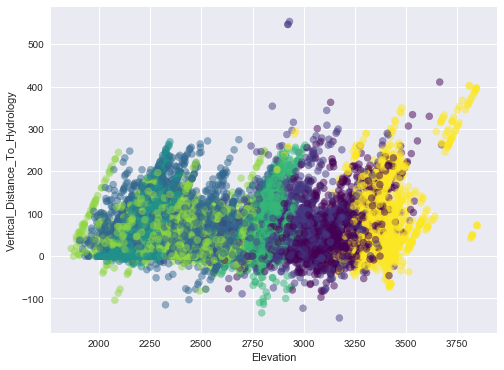

In [156]:
my_scatter(data.Elevation, data.Vertical_Distance_To_Hydrology)

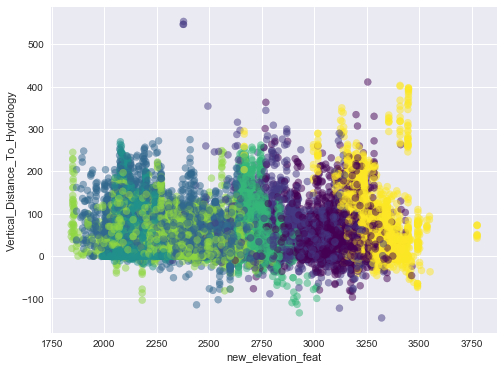

In [157]:
def new_elevation_feat(data):
    new_data = data.copy(deep=True)
    new_feature = new_data.Elevation - new_data.Vertical_Distance_To_Hydrology
    new_data['new_elevation_feat'] = new_feature
    return new_data

new_data = new_elevation_feat(data)
my_scatter(new_data.new_elevation_feat, new_data.Vertical_Distance_To_Hydrology)

In [158]:
print_base_results(new_data)

Base RFC: 0.8174, New RFC: 0.8337
Base LR:  0.6772, New LR:  0.6766


### New Elevation Feature with Horizontal Hydro

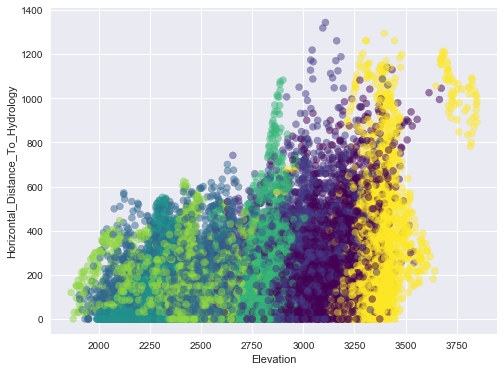

In [159]:
my_scatter(data.Elevation, data.Horizontal_Distance_To_Hydrology)

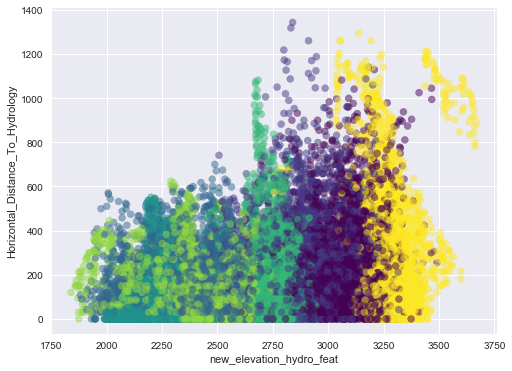

In [160]:
def new_elevation_hydro_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_elevation_hydro_feat'] = new_data.Elevation - new_data.Horizontal_Distance_To_Hydrology * .2
    return new_data

new_data = new_elevation_hydro_feat(data)
my_scatter(new_data.new_elevation_hydro_feat, data.Horizontal_Distance_To_Hydrology)

In [161]:
print_base_results(new_data)

Base RFC: 0.8174, New RFC: 0.8269
Base LR:  0.6772, New LR:  0.6764


### New Elevation Feature adjusted for Fire Points

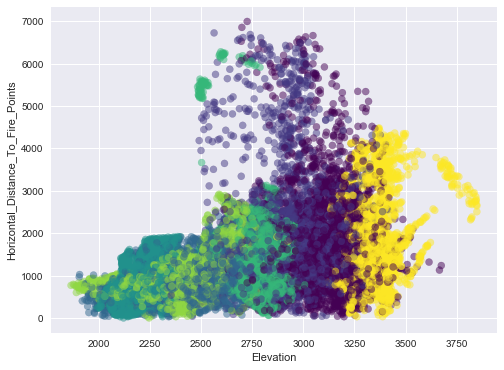

In [162]:
my_scatter(data.Elevation, data.Horizontal_Distance_To_Fire_Points)

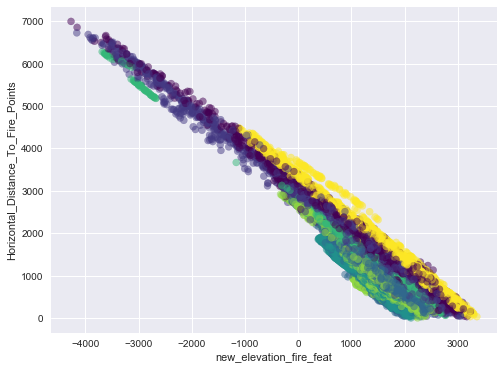

In [163]:
def new_elevation_fire_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_elevation_fire_feat'] = new_data.Elevation - new_data.Horizontal_Distance_To_Fire_Points
    return new_data

new_data = new_elevation_fire_feat(data)
my_scatter(new_data.new_elevation_fire_feat, data.Horizontal_Distance_To_Fire_Points)

In [164]:
print_base_results(new_data)

Base RFC: 0.8174, New RFC: 0.8373
Base LR:  0.6772, New LR:  0.6770


### New Elevation Feature adjusted for Roadways

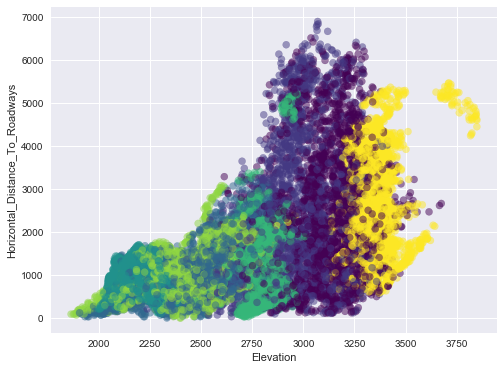

In [165]:
my_scatter(data.Elevation, data.Horizontal_Distance_To_Roadways)

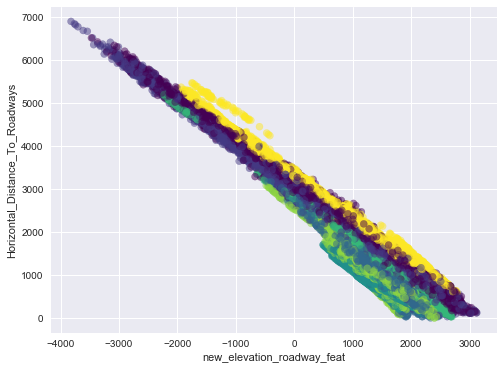

In [166]:
def new_elevation_roadway_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_elevation_roadway_feat'] = new_data.Elevation - new_data.Horizontal_Distance_To_Roadways
    return new_data

new_data = new_elevation_roadway_feat(data)
my_scatter(new_data.new_elevation_roadway_feat, data.Horizontal_Distance_To_Roadways)

In [167]:
print_base_results(new_data)

Base RFC: 0.8174, New RFC: 0.8343
Base LR:  0.6772, New LR:  0.6770


### New Hillshade Feature

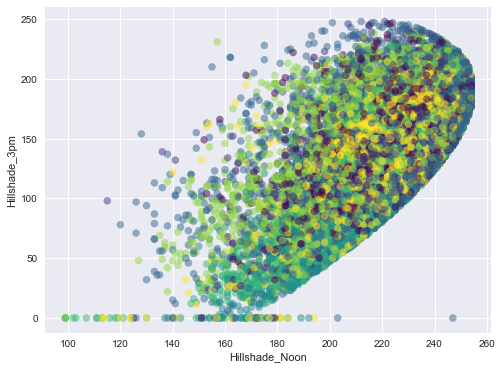

In [175]:
my_scatter(data.Hillshade_Noon, data.Hillshade_3pm)

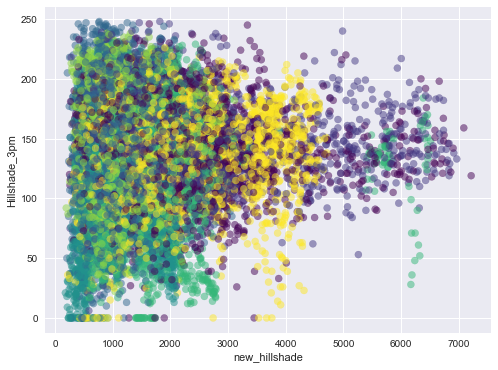

In [176]:
def new_hillshade_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_hillshade'] = new_data.Hillshade_Noon + new_data.Horizontal_Distance_To_Fire_Points
    return new_data

new_data = new_hillshade_feat(data)
my_scatter(new_data.new_hillshade, new_data.Hillshade_3pm)

In [177]:
print_base_results(new_data)

Base RFC: 0.8174, New RFC: 0.8401
Base LR:  0.6772, New LR:  0.6772


### New Hillshade_Hillshade Feature

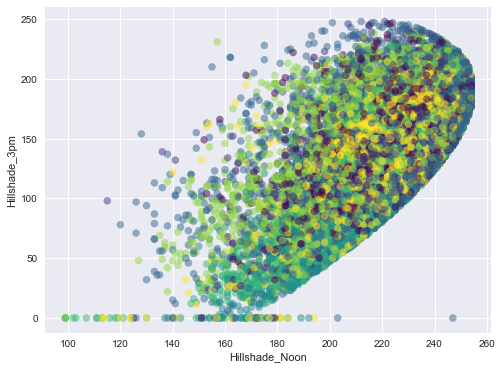

In [178]:
my_scatter(data.Hillshade_Noon, data.Hillshade_3pm)

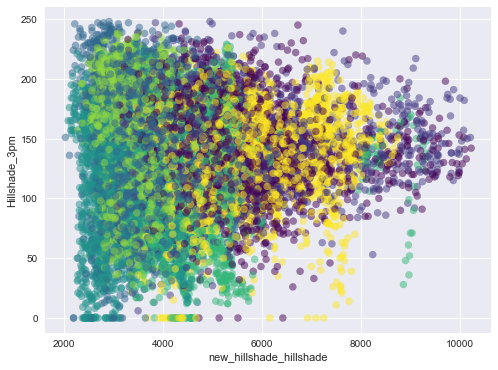

In [179]:
def new_hillshade_hillshade_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_hillshade_hillshade'] = new_data.Hillshade_Noon - new_data.Aspect + \
        new_data.Horizontal_Distance_To_Fire_Points + new_data.Elevation + new_data.Horizontal_Distance_To_Hydrology
    return new_data

new_data = new_hillshade_hillshade_feat(data)
my_scatter(new_data.new_hillshade_hillshade, new_data.Hillshade_3pm)

In [180]:
print_base_results(new_data)

Base RFC: 0.8174, New RFC: 0.8305
Base LR:  0.6772, New LR:  0.6772


# Parameter Tuning With New Features

In [181]:

### Add new features 
def get_new_features_data_rf(data):
    new_feature_funcs = [mean_disturb_feat, mean_fire_hydro_feat, new_elevation_feat,
                         new_elevation_hydro_feat, new_elevation_fire_feat, new_elevation_roadway_feat, new_hillshade_feat,
                         new_hillshade_hillshade_feat]
    new_data = data.copy(deep=True)
    for func in new_feature_funcs:
        new_data = func(new_data)

    return new_data

new_data = get_new_features_data_rf(data)
new_data.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6279                 1                 0   
1                                6225                 1                 0   
2                                6121                 1                 0   
3                                6211                 1                 0   
4                                6172                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0            1   
2            0        

## Random Forest

In [186]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)

pipe = make_pipeline(RandomForestClassifier())

param_grid = {
    'randomforestclassifier__n_estimators': [1000,], 
    'randomforestclassifier__criterion': ['entropy',],
    'randomforestclassifier__max_features': ['sqrt'],
    'randomforestclassifier__max_depth': [None, 35, 50],
    'randomforestclassifier__bootstrap': [False],
}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
%time grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.0min finished


Wall time: 3min 52s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__n_estimators': [1000], 'randomforestclassifier__max_depth': [None, 35, 50], 'randomforestclassifier__criterion': ['entropy'], 'randomforestclassifier__bootstrap': [False], 'randomforestclassifier__max_features': ['sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [187]:
print(grid.best_params_)
best_rfc = grid.best_estimator_
y_pred = best_rfc.predict(X_test)
print(np.mean(y_pred == y_test))
print(classification_report(y_test, y_pred, target_names=target_names))

{'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__max_depth': 35, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_features': 'sqrt'}
0.89498997996
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.81      0.81      0.81       679
   2 - Lodgepole Pine       0.83      0.73      0.78       722
   3 - Ponderosa Pine       0.88      0.88      0.88       704
4 - Cottonwood/Willow       0.95      0.98      0.97       739
            5 - Aspen       0.91      0.96      0.94       721
      6 - Douglas-fir       0.90      0.91      0.91       722
        7 - Krummholz       0.96      0.99      0.97       703

          avg / total       0.89      0.89      0.89      4990



In [93]:
# Show importance of new features

features = best_rfc.named_steps['randomforestclassifier'].feature_importances_
features = sorted(zip(features, new_data.columns), reverse=True)

for f in features:
    print('{:6.4f}, {}'.format(f[0], f[1]))

0.1479, new_elevation_hydro
0.1460, new_elevation_feat
0.1347, Elevation
0.0518, mean_disturb
0.0487, Horizontal_Distance_To_Roadways
0.0450, new_hillshade_hillshade
0.0381, Wilderness_Area4
0.0320, Horizontal_Distance_To_Hydrology
0.0317, mean_fire_hydro
0.0289, new_hillshade
0.0286, Horizontal_Distance_To_Fire_Points
0.0277, Vertical_Distance_To_Hydrology
0.0275, Hillshade_9am
0.0249, Aspect
0.0226, Hillshade_Noon
0.0217, Hillshade_3pm
0.0176, Wilderness_Area1
0.0167, Slope
0.0159, Wilderness_Area3
0.0158, Soil_Type10
0.0094, Soil_Type3
0.0090, Soil_Type38
0.0077, Soil_Type39
0.0067, Soil_Type4
0.0042, Soil_Type30
0.0035, Soil_Type29
0.0034, Soil_Type40
0.0033, Soil_Type2
0.0030, Soil_Type17
0.0027, Soil_Type32
0.0026, Soil_Type23
0.0024, Wilderness_Area2
0.0023, Soil_Type33
0.0022, Soil_Type22
0.0021, Soil_Type13
0.0019, Soil_Type6
0.0018, Soil_Type12
0.0016, Soil_Type11
0.0010, Soil_Type31
0.0010, Soil_Type24
0.0009, Soil_Type20
0.0007, Soil_Type5
0.0007, Soil_Type1
0.0005, Soil_Ty

## Extra Trees

In [68]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)

pipe = make_pipeline(ExtraTreesClassifier())

param_grid = {
    'extratreesclassifier__n_estimators': [1000, 2000, 3000], 
    'extratreesclassifier__criterion': ['entropy', 'gini'],
    'extratreesclassifier__max_features': ['auto','sqrt', 'log2', None],
    'extratreesclassifier__max_depth': [25, 30, 35],
    'extratreesclassifier__bootstrap': [True, False],
}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
%time grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 94.8min finished


CPU times: user 35.1 s, sys: 5.43 s, total: 40.5 s
Wall time: 1h 35min 14s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('extratreesclassifier', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'extratreesclassifier__max_features': ['auto', 'sqrt', 'log2', None], 'extratreesclassifier__max_depth': [25, 30, 35], 'extratreesclassifier__n_estimators': [1000, 2000, 3000], 'extratreesclassifier__bootstrap': [True, False], 'extratreesclassifier__criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [69]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

{'extratreesclassifier__max_features': 'auto', 'extratreesclassifier__max_depth': 35, 'extratreesclassifier__n_estimators': 2000, 'extratreesclassifier__bootstrap': False, 'extratreesclassifier__criterion': 'entropy'}
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.81      0.79      0.80       679
   2 - Lodgepole Pine       0.82      0.73      0.77       722
   3 - Ponderosa Pine       0.88      0.86      0.87       704
4 - Cottonwood/Willow       0.93      0.98      0.95       739
            5 - Aspen       0.92      0.97      0.94       721
      6 - Douglas-fir       0.89      0.90      0.90       722
        7 - Krummholz       0.96      0.98      0.97       703

          avg / total       0.89      0.89      0.89      4990



## SVM

In [75]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)
svm_pipe = make_pipeline(StandardScaler(), SVC())

param_grid = {
    'svc__kernel': ['linear', 'rbf'],  
    'svc__C': [50, 100, 200], 
    'svc__gamma': [.01, .05, .1]
} 
grid = GridSearchCV(svm_pipe, param_grid, cv=5, n_jobs=-1)
%time grid.fit(X_train, y_train)

CPU times: user 5.59 s, sys: 307 ms, total: 5.89 s
Wall time: 11min 5s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svc__C': [50, 100, 200], 'svc__kernel': ['linear', 'rbf'], 'svc__gamma': [0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [76]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

{'svc__C': 100, 'svc__kernel': 'rbf', 'svc__gamma': 0.05}
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.73      0.73      0.73       679
   2 - Lodgepole Pine       0.73      0.66      0.69       722
   3 - Ponderosa Pine       0.82      0.77      0.79       704
4 - Cottonwood/Willow       0.91      0.96      0.93       739
            5 - Aspen       0.88      0.93      0.91       721
      6 - Douglas-fir       0.83      0.85      0.84       722
        7 - Krummholz       0.94      0.97      0.95       703

          avg / total       0.84      0.84      0.84      4990



With parameter tuning, we were able to get the accuracy up to.

# Error analysis

Helper Functions

In [94]:
def create_confusion_matrix(y_test, y_pred, title='Confusion matrix, without normalization'):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title=title)
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

In [95]:
rfc = best_rfc.get_params()['randomforestclassifier']

In [96]:
new_data = get_new_features_data_rf(data)
X_train, y_train, X_test, y_test = split_data(new_data, labels)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(np.mean(y_pred == y_test))

0.887775551102


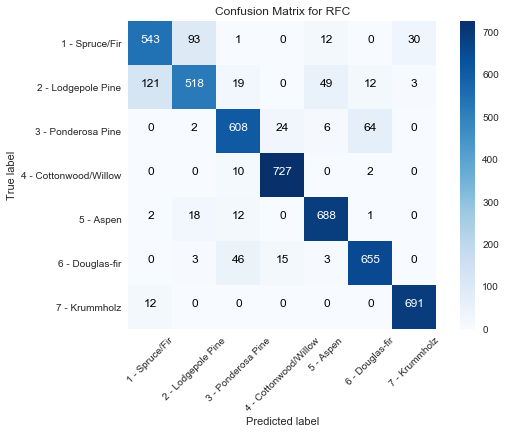

In [97]:
create_confusion_matrix(y_test, y_pred, title="Confusion Matrix for RFC")

It looks like there's some confusion concerning classes 1 & 2 as well as classes 3 & 6. Let's see if there's any data that might shed some light on why these pairs exist, and how we might get around the confusion.

In [98]:
# look at the biggest errors:
# get the probabilites for each example
probs = rfc.predict_proba(X_test)

# get the max probability for each example
max_probs = np.max(probs, axis=1)

# get the probs of the true label
true_label_probs = probs[np.arange(len(probs)), y_test-1]

r_ratio = max_probs / true_label_probs

# get the indexes for the top 3 R ratio
indexes = np.argpartition(r_ratio, -3)[-3:]

for index in indexes:
    print('\n============\n')
    print(index)
    print(X_test.iloc[index], '\n')
    print('True label:', y_test.iloc[index])
    print('Predicated label:', y_pred[index])
    print('Probability of labels: {}'.format(probs[index]))



1792
Elevation                             2244.000000
Aspect                                  34.000000
Slope                                    9.000000
Horizontal_Distance_To_Hydrology         0.000000
Vertical_Distance_To_Hydrology           0.000000
Horizontal_Distance_To_Roadways       1537.000000
Hillshade_9am                          219.000000
Hillshade_Noon                         221.000000
Hillshade_3pm                          137.000000
Horizontal_Distance_To_Fire_Points    1080.000000
Wilderness_Area1                         0.000000
Wilderness_Area2                         0.000000
Wilderness_Area3                         0.000000
Wilderness_Area4                         1.000000
Soil_Type1                               0.000000
Soil_Type2                               0.000000
Soil_Type3                               0.000000
Soil_Type4                               0.000000
Soil_Type5                               0.000000
Soil_Type6                               0.

/Users/chrisfleisch/anaconda3/envs/w207_final/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide


### Cover Type 1 General Errors

In [99]:
# look at errors with cover type 1 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 1) & (y_test == 1)
X_errors = X_errors[error_msk]
X_errors.head(10)

true  pred  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
2119      1     2       2900     127     11                                30   
1086      1     2       2960      84     10                                30   
9844      1     2       3082     275     11                               592   
9295      1     7       3263     143     19                               180   
1022      1     2       3049     268     18                               537   
6786      1     5       2712     213     18                                67   
9804      1     2       2819     319     25                               120   
14677     1     2       3019      44     19                               752   
11903     1     7       3309      14      7                               390   
286       1     7       3201     331      5                                 0   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
2119                               -1                             1384   
1086                                5                             3660   
9844                              166                             3258   
9295                               39                             2873   
1022                              112                             6001   
6786                               14                              918   
9804                               48                              600   
14677                             124                             1282   
11903                              81                             3900   
286                                 0                             4002   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
2119             239             232            122   
1086             234             224            121   
9844             189             243            193   
9295             243             233            110   
1022             172             244            210   
6786             201             254            183   
9804             148             208            196   
14677            221             196            103   
11903            213             225            149   
286              208             234            164   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
2119                                 2524                 0                 0   
1086                                 2579                 1                 0   
9844                                 2097                 0                 0   
9295                                 3032                 0                 0   
1022                                 1660                 1                 0   
6786                                 1922                 0                 0   
9804                                 1033                 0                 0   
14677                                1945                 0                 0   
11903                                1410                 1                 0   
286                                  3460                 1                 0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
2119                  1                 0           0           0           0   
1086                  0                 0           0           0           0   
9844                  1                 0           0           0           0   
9295                  1                 0           0           0           0   
1022                  0                 0           0           0           0   
6786                  1                 0           0           0           0   
9804                  1                 0           0           0           0   
14677                 1                 0           0           0           0   
11903                 0                 0           0           0        

In [100]:
# Describe the accurate predictions
true_msk = (y_pred == 1) & (y_test == 1)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   543.000000  543.000000  543.000000                        543.000000   
mean   3156.322284  158.491713   12.791897                        278.165746   
std     129.500863  117.854323    6.616747                        224.304415   
min    2739.000000    0.000000    1.000000                          0.000000   
25%    3068.500000   50.000000    8.000000                        108.000000   
50%    3163.000000  123.000000   12.000000                        218.000000   
75%    3242.000000  289.500000   16.000000                        401.000000   
max    3666.000000  359.000000   38.000000                       1041.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      543.000000                       543.000000   
mean                        41.640884                      2591.259669   
std                         58.072435                      1500.135598   
min                        -81.000000                       150.000000   
25%                          3.000000                      1406.500000   
50%                         24.000000                      2396.000000   
75%                         57.000000                      3627.500000   
max                        411.000000                      6300.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     543.000000      543.000000     543.000000   
mean      211.837937      223.865562     144.896869   
std        24.195992       17.718545      35.194668   
min       104.000000      152.000000      25.000000   
25%       200.000000      214.000000     123.000000   
50%       216.000000      226.000000     145.000000   
75%       228.000000      236.000000     167.000000   
max       254.000000      254.000000     234.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          543.000000        543.000000        543.000000   
mean                          1949.434622          0.495396          0.103131   
std                           1282.199794          0.500440          0.304410   
min                             42.000000          0.000000          0.000000   
25%                            966.000000          0.000000          0.000000   
50%                           1698.000000          0.000000          0.000000   
75%                           2709.000000          1.000000          0.000000   
max                           6632.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        543.000000             543.0       543.0       543.0       543.0   
mean           0.401473               0.0         0.0         0.0         0.0   
std            0.490648               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count       543.0       543.0       543.0       543.0       543.0       543.0   
mean          0.0         0.0         0.0         0.0         0.0         0.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           0.0         0.0         0.0         0.0         0.0         0.0   
75%           0.0         0.0         0.0         0.0         0.0         0.0   
max           0.0

In [101]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   136.000000  136.000000  136.000000                        136.000000   
mean   3006.463235  163.080882   12.544118                        276.867647   
std     214.999635  111.003440    6.340777                        272.420639   
min    2579.000000    1.000000    2.000000                          0.000000   
25%    2858.500000   65.500000    7.750000                         67.000000   
50%    2956.000000  124.000000   12.000000                        180.000000   
75%    3145.250000  268.500000   17.000000                        446.000000   
max    3473.000000  359.000000   34.000000                       1129.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      136.000000                       136.000000   
mean                        46.772059                      2404.161765   
std                         64.153631                      1574.482115   
min                        -80.000000                       134.000000   
25%                          5.000000                      1081.500000   
50%                         21.000000                      2143.500000   
75%                         67.750000                      3510.250000   
max                        301.000000                      6001.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     136.000000      136.000000     136.000000   
mean      214.779412      224.867647     142.345588   
std        22.683879       17.839535      36.511871   
min       147.000000      162.000000       0.000000   
25%       202.750000      214.000000     119.750000   
50%       218.000000      226.500000     144.000000   
75%       231.250000      238.000000     169.000000   
max       254.000000      254.000000     216.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          136.000000        136.000000        136.000000   
mean                          2144.691176          0.433824          0.051471   
std                           1397.337185          0.497434          0.221772   
min                            124.000000          0.000000          0.000000   
25%                           1241.250000          0.000000          0.000000   
50%                           1859.500000          0.000000          0.000000   
75%                           2581.250000          1.000000          0.000000   
max                           6993.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        136.000000             136.0       136.0       136.0       136.0   
mean           0.514706               0.0         0.0         0.0         0.0   
std            0.501631               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            1.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  136.000000       136.0       136.0       136.0       136.0  136.000000   
mean     0.029412         0.0         0.0         0.0         0.0    0.007353   
std      0.169582         0.0         0.0         0.0         0.0    0.085749   
min      0.000000         0.0         0.0         0.0         0.0    0.000000   
25%      0.000000         0.0         0.0         0.0         0.0    0.000000   
50%      0.000000         0.0         0.0         0.0         0.0    0.000000   
75%      0.000000         0.0         0.0         0.0         0.0    0.000000   
max      1.000000

We can see that the erors have a lower mean elevation. Their vertical distance is a little higher and distance to roadways is also lower.

### Cover Type 1 Predicted 2 Errors

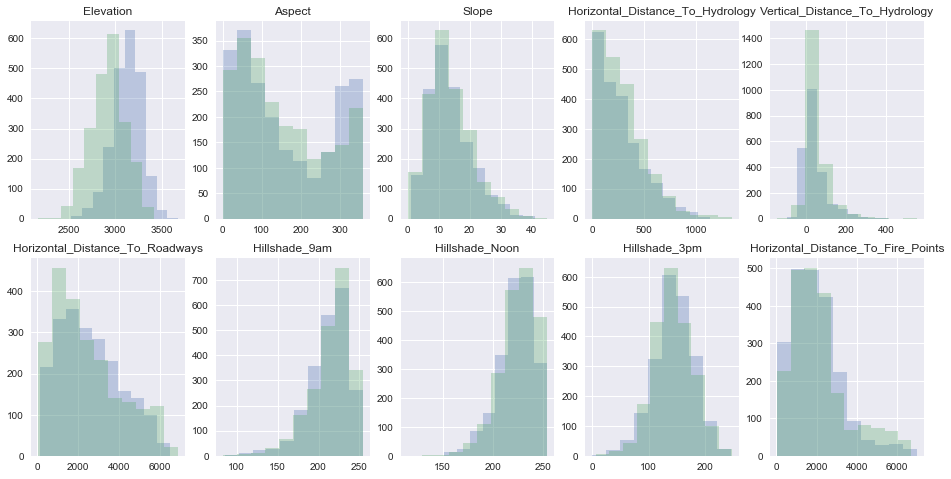

In [102]:
#Display the data between classes 1 and 2
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in [1, 2]:
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

Well that explains a lot. These classes are nearly identical. Let's dig a bit deeper though and see look specifically at the 1s that were mistaken for 2s.

In [103]:
# look at errors with cover type 1 where the prediction was class 2
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred == 2) & (y_test == 1)
X_errors = X_errors[error_msk]

In [104]:
# Describe the accurate predictions
true_msk = (y_pred == 1) & (y_test == 1)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   543.000000  543.000000  543.000000                        543.000000   
mean   3156.322284  158.491713   12.791897                        278.165746   
std     129.500863  117.854323    6.616747                        224.304415   
min    2739.000000    0.000000    1.000000                          0.000000   
25%    3068.500000   50.000000    8.000000                        108.000000   
50%    3163.000000  123.000000   12.000000                        218.000000   
75%    3242.000000  289.500000   16.000000                        401.000000   
max    3666.000000  359.000000   38.000000                       1041.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      543.000000                       543.000000   
mean                        41.640884                      2591.259669   
std                         58.072435                      1500.135598   
min                        -81.000000                       150.000000   
25%                          3.000000                      1406.500000   
50%                         24.000000                      2396.000000   
75%                         57.000000                      3627.500000   
max                        411.000000                      6300.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     543.000000      543.000000     543.000000   
mean      211.837937      223.865562     144.896869   
std        24.195992       17.718545      35.194668   
min       104.000000      152.000000      25.000000   
25%       200.000000      214.000000     123.000000   
50%       216.000000      226.000000     145.000000   
75%       228.000000      236.000000     167.000000   
max       254.000000      254.000000     234.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          543.000000        543.000000        543.000000   
mean                          1949.434622          0.495396          0.103131   
std                           1282.199794          0.500440          0.304410   
min                             42.000000          0.000000          0.000000   
25%                            966.000000          0.000000          0.000000   
50%                           1698.000000          0.000000          0.000000   
75%                           2709.000000          1.000000          0.000000   
max                           6632.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        543.000000             543.0       543.0       543.0       543.0   
mean           0.401473               0.0         0.0         0.0         0.0   
std            0.490648               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count       543.0       543.0       543.0       543.0       543.0       543.0   
mean          0.0         0.0         0.0         0.0         0.0         0.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           0.0         0.0         0.0         0.0         0.0         0.0   
75%           0.0         0.0         0.0         0.0         0.0         0.0   
max           0.0

In [105]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count    93.000000   93.000000  93.000000                         93.000000   
mean   2934.774194  154.774194  13.021505                        244.494624   
std     116.115678  114.182170   6.181984                        223.358973   
min    2579.000000    1.000000   2.000000                          0.000000   
25%    2863.000000   61.000000   8.000000                         67.000000   
50%    2937.000000  108.000000  12.000000                        170.000000   
75%    3004.000000  270.000000  17.000000                        362.000000   
max    3215.000000  356.000000  34.000000                        900.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       93.000000                        93.000000   
mean                        42.473118                      2550.010753   
std                         57.941798                      1731.756419   
min                        -80.000000                       134.000000   
25%                          5.000000                      1082.000000   
50%                         20.000000                      2270.000000   
75%                         60.000000                      3726.000000   
max                        301.000000                      6001.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count      93.000000       93.000000      93.000000   
mean      214.526882      222.322581     139.870968   
std        24.689635       16.898136      38.605932   
min       147.000000      162.000000       0.000000   
25%       198.000000      214.000000     118.000000   
50%       221.000000      225.000000     135.000000   
75%       232.000000      232.000000     168.000000   
max       254.000000      251.000000     216.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                           93.000000         93.000000              93.0   
mean                          2315.129032          0.526882               0.0   
std                           1533.527826          0.501983               0.0   
min                            124.000000          0.000000               0.0   
25%                           1243.000000          0.000000               0.0   
50%                           1926.000000          1.000000               0.0   
75%                           2879.000000          1.000000               0.0   
max                           6993.000000          1.000000               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         93.000000              93.0        93.0        93.0        93.0   
mean           0.473118               0.0         0.0         0.0         0.0   
std            0.501983               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count        93.0        93.0        93.0        93.0        93.0   93.000000   
mean          0.0         0.0         0.0         0.0         0.0    0.010753   
std           0.0         0.0         0.0         0.0         0.0    0.103695   
min           0.0         0.0         0.0         0.0         0.0    0.000000   
25%           0.0         0.0         0.0         0.0         0.0    0.000000   
50%           0.0         0.0         0.0         0.0         0.0    0.000000   
75%           0.0         0.0         0.0         0.0         0.0    0.000000   
max           0.0         

It appears that the mean Horizontal_Distance_To_Fire_Points was about 1.14x the distance from the accurately predicted class 1s. That really seems to be the most glaring disparity here. 

Median elevations: True: 3163.000000, Error: 2937.000000, (92.854885%)
Median distance to fire: True: 1698.000000, Error: 1926.000000, (113.427562%)


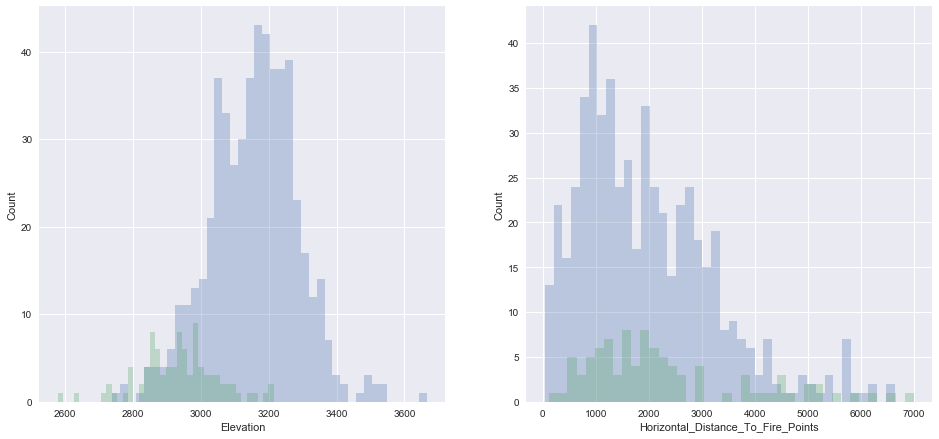

In [106]:
plt.figure(figsize=(16,16)) 

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
print("Median elevations: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Elevation), np.median(X_errors.Elevation), (np.median(X_errors.Elevation)/ np.median(X_true.Elevation) * 100)))
print("Median distance to fire: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Fire_Points), np.median(X_errors.Horizontal_Distance_To_Fire_Points), (np.median(X_errors.Horizontal_Distance_To_Fire_Points) / np.median(X_true.Horizontal_Distance_To_Fire_Points) * 100)))

plt.subplot(221)
plt.hist(X_true.Elevation, **kwargs)
plt.hist(X_errors.Elevation, **kwargs);
plt.xlabel("Elevation") 
plt.ylabel("Count")

plt.subplot(222)
plt.hist(X_true.Horizontal_Distance_To_Fire_Points, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Fire_Points, **kwargs);
plt.xlabel("Horizontal_Distance_To_Fire_Points") 
plt.ylabel("Count")
plt.show()

### Cover Type 2 Errors

In [107]:
# look at errors with cover type 2 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 2) & (y_test == 2)
X_errors = X_errors[error_msk]

In [108]:
# Describe the accurate predictions
true_msk = (y_pred == 2) & (y_test == 2)
X_true = X_test[true_msk]
X_true.describe()

Elevation     Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   518.000000  518.00000  518.000000                        518.000000   
mean   2904.812741  145.34749   13.372587                        306.496139   
std     162.481964  105.69592    6.987844                        225.580324   
min    2512.000000    0.00000    1.000000                          0.000000   
25%    2804.250000   54.00000    8.000000                        150.000000   
50%    2920.000000  123.50000   12.500000                        258.000000   
75%    3001.000000  219.75000   17.000000                        430.000000   
max    3387.000000  357.00000   40.000000                       1127.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      518.000000                       518.000000   
mean                        48.297297                      2423.505792   
std                         60.934759                      1586.382238   
min                        -89.000000                        95.000000   
25%                          9.000000                      1138.500000   
50%                         32.000000                      2053.500000   
75%                         69.750000                      3311.250000   
max                        554.000000                      6890.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     518.000000      518.000000     518.000000   
mean      213.996139      225.237452     142.972973   
std        25.497449       17.425930      33.192936   
min        95.000000      141.000000      44.000000   
25%       204.000000      214.000000     120.250000   
50%       220.000000      227.000000     141.000000   
75%       231.750000      239.000000     162.750000   
max       253.000000      254.000000     248.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          518.000000        518.000000        518.000000   
mean                          2279.839768          0.584942          0.013514   
std                           1444.802754          0.493208          0.115571   
min                             95.000000          0.000000          0.000000   
25%                           1257.500000          0.000000          0.000000   
50%                           1945.000000          1.000000          0.000000   
75%                           2711.250000          1.000000          0.000000   
max                           6723.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        518.000000        518.000000       518.0       518.0  518.000000   
mean           0.399614          0.001931         0.0         0.0    0.005792   
std            0.490292          0.043937         0.0         0.0    0.075955   
min            0.000000          0.000000         0.0         0.0    0.000000   
25%            0.000000          0.000000         0.0         0.0    0.000000   
50%            0.000000          0.000000         0.0         0.0    0.000000   
75%            1.000000          0.000000         0.0         0.0    0.000000   
max            1.000000          1.000000         0.0         0.0    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  518.000000       518.0  518.000000       518.0       518.0  518.000000   
mean     0.005792         0.0    0.001931         0.0         0.0    0.003861   
std      0.075955         0.0    0.043937         0.0         0.0    0.062077   
min      0.000000         0.0    0.000000         0.0         0.0    0.000000   
25%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
50%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
75%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
max      1.000000         

In [109]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   204.000000  204.000000  204.000000                        204.000000   
mean   2963.299020  152.995098   14.308824                        246.426471   
std     230.258676  105.231132    7.312700                        183.689794   
min    2353.000000    0.000000    0.000000                          0.000000   
25%    2769.750000   64.500000    9.000000                         95.000000   
50%    3035.000000  133.500000   13.500000                        212.000000   
75%    3143.000000  224.250000   19.000000                        339.750000   
max    3402.000000  358.000000   35.000000                        924.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      204.000000                       204.000000   
mean                        41.225490                      2165.818627   
std                         55.680458                      1549.271741   
min                       -146.000000                        30.000000   
25%                          4.000000                      1072.000000   
50%                         25.500000                      1669.500000   
75%                         61.000000                      3054.000000   
max                        262.000000                      6679.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     204.000000      204.000000     204.000000   
mean      216.676471      224.720588     138.348039   
std        23.453407       19.054378      37.258139   
min       142.000000      165.000000      19.000000   
25%       203.750000      215.000000     116.000000   
50%       222.000000      228.000000     136.500000   
75%       234.000000      238.000000     163.500000   
max       253.000000      254.000000     224.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          204.000000        204.000000        204.000000   
mean                          1737.897059          0.367647          0.073529   
std                           1079.011623          0.483351          0.261646   
min                             42.000000          0.000000          0.000000   
25%                           1055.500000          0.000000          0.000000   
50%                           1567.500000          0.000000          0.000000   
75%                           2254.250000          1.000000          0.000000   
max                           6368.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        204.000000        204.000000       204.0       204.0  204.000000   
mean           0.544118          0.014706         0.0         0.0    0.014706   
std            0.499275          0.120669         0.0         0.0    0.120669   
min            0.000000          0.000000         0.0         0.0    0.000000   
25%            0.000000          0.000000         0.0         0.0    0.000000   
50%            1.000000          0.000000         0.0         0.0    0.000000   
75%            1.000000          0.000000         0.0         0.0    0.000000   
max            1.000000          1.000000         0.0         0.0    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  204.000000       204.0  204.000000       204.0       204.0       204.0   
mean     0.044118         0.0    0.009804         0.0         0.0         0.0   
std      0.205862         0.0    0.098771         0.0         0.0         0.0   
min      0.000000         0.0    0.000000         0.0         0.0         0.0   
25%      0.000000         0.0    0.000000         0.0         0.0         0.0   
50%      0.000000         0.0    0.000000         0.0         0.0         0.0   
75%      0.000000         0.0    0.000000         0.0         0.0         0.0   
max      1.000000

### Cover Type 2 Predicted 1 Errors

In [110]:
# look at errors with cover type 1 where the prediction was class 2
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred == 1) & (y_test == 2)
X_errors = X_errors[error_msk]

In [111]:
# Describe the accurate predictions
true_msk = (y_pred == 2) & (y_test == 2)
X_true = X_test[true_msk]
X_true.describe()

Elevation     Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   518.000000  518.00000  518.000000                        518.000000   
mean   2904.812741  145.34749   13.372587                        306.496139   
std     162.481964  105.69592    6.987844                        225.580324   
min    2512.000000    0.00000    1.000000                          0.000000   
25%    2804.250000   54.00000    8.000000                        150.000000   
50%    2920.000000  123.50000   12.500000                        258.000000   
75%    3001.000000  219.75000   17.000000                        430.000000   
max    3387.000000  357.00000   40.000000                       1127.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      518.000000                       518.000000   
mean                        48.297297                      2423.505792   
std                         60.934759                      1586.382238   
min                        -89.000000                        95.000000   
25%                          9.000000                      1138.500000   
50%                         32.000000                      2053.500000   
75%                         69.750000                      3311.250000   
max                        554.000000                      6890.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     518.000000      518.000000     518.000000   
mean      213.996139      225.237452     142.972973   
std        25.497449       17.425930      33.192936   
min        95.000000      141.000000      44.000000   
25%       204.000000      214.000000     120.250000   
50%       220.000000      227.000000     141.000000   
75%       231.750000      239.000000     162.750000   
max       253.000000      254.000000     248.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          518.000000        518.000000        518.000000   
mean                          2279.839768          0.584942          0.013514   
std                           1444.802754          0.493208          0.115571   
min                             95.000000          0.000000          0.000000   
25%                           1257.500000          0.000000          0.000000   
50%                           1945.000000          1.000000          0.000000   
75%                           2711.250000          1.000000          0.000000   
max                           6723.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        518.000000        518.000000       518.0       518.0  518.000000   
mean           0.399614          0.001931         0.0         0.0    0.005792   
std            0.490292          0.043937         0.0         0.0    0.075955   
min            0.000000          0.000000         0.0         0.0    0.000000   
25%            0.000000          0.000000         0.0         0.0    0.000000   
50%            0.000000          0.000000         0.0         0.0    0.000000   
75%            1.000000          0.000000         0.0         0.0    0.000000   
max            1.000000          1.000000         0.0         0.0    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  518.000000       518.0  518.000000       518.0       518.0  518.000000   
mean     0.005792         0.0    0.001931         0.0         0.0    0.003861   
std      0.075955         0.0    0.043937         0.0         0.0    0.062077   
min      0.000000         0.0    0.000000         0.0         0.0    0.000000   
25%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
50%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
75%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
max      1.000000         

In [112]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   121.000000  121.000000  121.000000                        121.000000   
mean   3118.801653  157.264463   13.355372                        262.454545   
std     105.504077  105.691356    6.404243                        192.080322   
min    2785.000000    2.000000    1.000000                          0.000000   
25%    3049.000000   73.000000    9.000000                        120.000000   
50%    3113.000000  130.000000   12.000000                        228.000000   
75%    3192.000000  236.000000   17.000000                        371.000000   
max    3402.000000  358.000000   34.000000                        924.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      121.000000                       121.000000   
mean                        35.280992                      2695.206612   
std                         52.793659                      1682.620793   
min                       -146.000000                       108.000000   
25%                          3.000000                      1218.000000   
50%                         23.000000                      2356.000000   
75%                         52.000000                      3830.000000   
max                        262.000000                      6679.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     121.000000      121.000000     121.000000   
mean      217.752066      225.363636     138.752066   
std        23.547923       17.372872      34.295355   
min       150.000000      165.000000      60.000000   
25%       205.000000      217.000000     116.000000   
50%       224.000000      227.000000     135.000000   
75%       235.000000      237.000000     166.000000   
max       251.000000      254.000000     220.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          121.000000        121.000000        121.000000   
mean                          1887.735537          0.487603          0.115702   
std                           1214.490193          0.501925          0.321198   
min                             42.000000          0.000000          0.000000   
25%                           1092.000000          0.000000          0.000000   
50%                           1766.000000          0.000000          0.000000   
75%                           2353.000000          1.000000          0.000000   
max                           6368.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        121.000000             121.0       121.0       121.0       121.0   
mean           0.396694               0.0         0.0         0.0         0.0   
std            0.491246               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count       121.0       121.0       121.0       121.0       121.0       121.0   
mean          0.0         0.0         0.0         0.0         0.0         0.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           0.0         0.0         0.0         0.0         0.0         0.0   
75%           0.0         0.0         0.0         0.0         0.0         0.0   
max           0.0

Median elevations: True: 2920.000000, Error: 3113.000000, (106.609589%)
Median distance to fire: True: 1945.000000, Error: 1766.000000, (90.796915%)


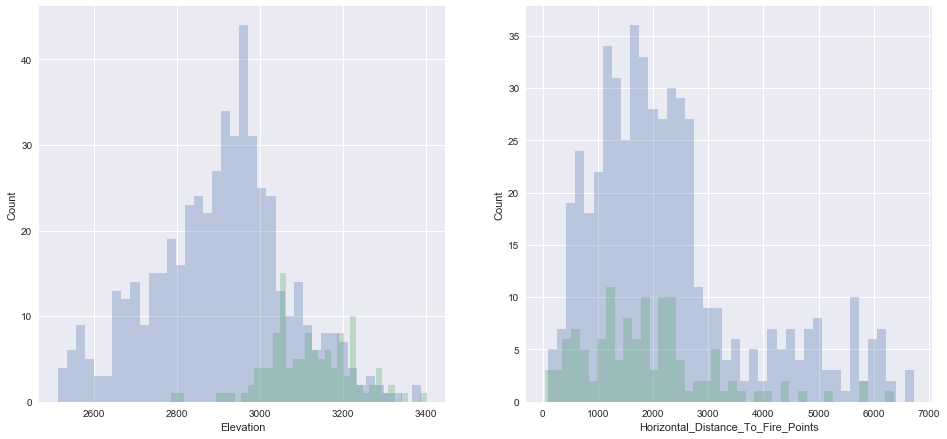

In [113]:
plt.figure(figsize=(16,16)) 

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
print("Median elevations: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Elevation), np.median(X_errors.Elevation), (np.median(X_errors.Elevation)/ np.median(X_true.Elevation) * 100)))
print("Median distance to fire: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Fire_Points), np.median(X_errors.Horizontal_Distance_To_Fire_Points), (np.median(X_errors.Horizontal_Distance_To_Fire_Points) / np.median(X_true.Horizontal_Distance_To_Fire_Points) * 100)))

plt.subplot(221)
plt.hist(X_true.Elevation, **kwargs)
plt.hist(X_errors.Elevation, **kwargs);
plt.xlabel("Elevation") 
plt.ylabel("Count")

plt.subplot(222)
plt.hist(X_true.Horizontal_Distance_To_Fire_Points, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Fire_Points, **kwargs);
plt.xlabel("Horizontal_Distance_To_Fire_Points") 
plt.ylabel("Count")
plt.show()

We see that this relationship between 1 & 2 with respect to fire is reciprocal in that the numbers are roughly flipped now that we're looking at 2s that were thought to be 1s.

### Cover Type 3 and 6 Errors

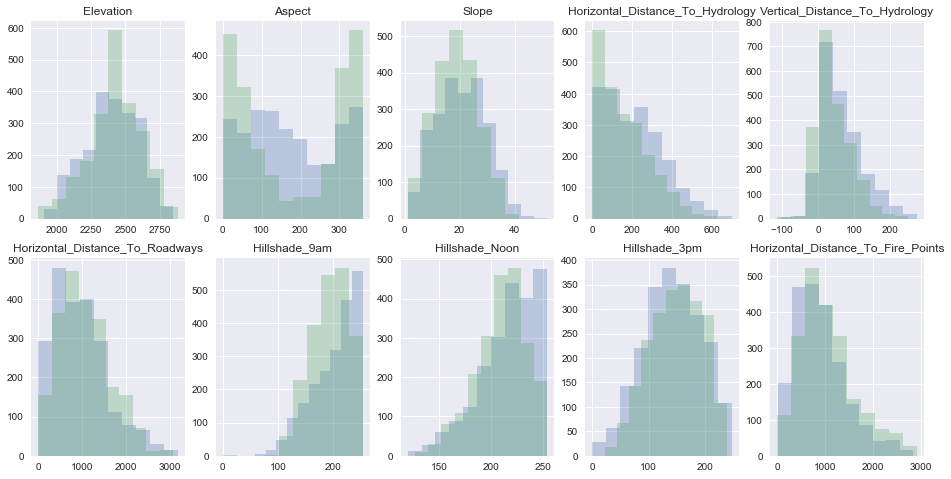

In [114]:
#Display the data between classes 3 and 6
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in [3, 6]:
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

These aren't terribly better than 1 & 2. Let's dive deeper and see if anything stands out.

### Cover Type 3 Errors

In [115]:
# look at errors with cover type 2 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 3) & (y_test == 3)
X_errors = X_errors[error_msk]

In [116]:
# Describe the accurate predictions
true_msk = (y_pred == 3) & (y_test == 3)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   608.000000  608.000000  608.000000                        608.000000   
mean   2389.498355  170.411184   21.134868                        213.292763   
std     195.833058  104.398719    8.917981                        139.377375   
min    1905.000000    0.000000    1.000000                          0.000000   
25%    2265.750000   90.000000   14.000000                         95.000000   
50%    2404.000000  153.000000   21.000000                        190.000000   
75%    2546.250000  260.250000   28.000000                        301.000000   
max    2823.000000  360.000000   44.000000                        700.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      608.000000                       608.000000   
mean                        65.912829                       934.623355   
std                         58.779267                       619.507150   
min                       -115.000000                        30.000000   
25%                         23.000000                       429.000000   
50%                         54.000000                       868.500000   
75%                         96.000000                      1298.500000   
max                        275.000000                      3164.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     608.000000      608.000000     608.000000   
mean      203.463816      216.077303     138.404605   
std        41.368939       28.375494      52.239161   
min        65.000000      133.000000       0.000000   
25%       172.750000      200.000000     102.000000   
50%       217.000000      222.000000     136.000000   
75%       237.000000      238.000000     178.000000   
max       254.000000      254.000000     247.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          608.000000             608.0             608.0   
mean                           899.988487               0.0               0.0   
std                            537.117536               0.0               0.0   
min                             30.000000               0.0               0.0   
25%                            491.000000               0.0               0.0   
50%                            829.000000               0.0               0.0   
75%                           1179.750000               0.0               0.0   
max                           2846.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        608.000000        608.000000  608.000000  608.000000  608.000000   
mean           0.391447          0.608553    0.065789    0.125000    0.059211   
std            0.488476          0.488476    0.248118    0.330991    0.236213   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  608.000000  608.000000  608.000000       608.0       608.0       608.0   
mean     0.248355    0.027961    0.106908         0.0         0.0         0.0   
std      0.432415    0.164995    0.309251         0.0         0.0         0.0   
min      0.000000    0.000000    0.000000         0.0         0.0         0.0   
25%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
50%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
75%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
max      1.000000

In [117]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count    96.000000   96.000000  96.000000                         96.000000   
mean   2386.291667  173.968750  16.895833                        133.197917   
std     218.423101  120.176489   8.110395                        121.841625   
min    1931.000000    2.000000   1.000000                          0.000000   
25%    2227.250000   59.000000  10.000000                         30.000000   
50%    2398.000000  150.500000  16.500000                        101.500000   
75%    2542.000000  293.250000  22.000000                        184.500000   
max    2806.000000  357.000000  37.000000                        474.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       96.000000                        96.000000   
mean                        28.677083                      1082.020833   
std                         40.006445                       583.438933   
min                        -30.000000                        30.000000   
25%                          2.750000                       627.000000   
50%                         14.000000                      1117.000000   
75%                         40.000000                      1426.000000   
max                        196.000000                      2841.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count      96.000000       96.000000      96.000000   
mean      204.312500      217.239583     141.031250   
std        31.689385       23.183363      46.882261   
min       118.000000      162.000000       0.000000   
25%       185.000000      197.750000     105.750000   
50%       210.500000      218.500000     145.500000   
75%       228.250000      236.250000     178.250000   
max       253.000000      254.000000     215.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                           96.000000              96.0              96.0   
mean                          1015.104167               0.0               0.0   
std                            542.665807               0.0               0.0   
min                            120.000000               0.0               0.0   
25%                            632.500000               0.0               0.0   
50%                            945.500000               0.0               0.0   
75%                           1262.250000               0.0               0.0   
max                           2525.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         96.000000         96.000000   96.000000   96.000000   96.000000   
mean           0.395833          0.604167    0.072917    0.072917    0.062500   
std            0.491596          0.491596    0.261365    0.261365    0.243332   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count   96.000000        96.0   96.000000        96.0        96.0        96.0   
mean     0.052083         0.0    0.135417         0.0         0.0         0.0   
std      0.223361         0.0    0.343964         0.0         0.0         0.0   
min      0.000000         0.0    0.000000         0.0         0.0         0.0   
25%      0.000000         0.0    0.000000         0.0         0.0         0.0   
50%      0.000000         0.0    0.000000         0.0         0.0         0.0   
75%      0.000000         0.0    0.000000         0.0         0.0         0.0   
max      1.000000         

### Cover Type 3 Predicted 6 Errors

In [118]:
# look at errors with cover type 1 where the prediction was class 2
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred == 6) & (y_test == 3)
X_errors = X_errors[error_msk]

In [119]:
# Describe the accurate predictions
true_msk = (y_pred == 3) & (y_test == 3)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   608.000000  608.000000  608.000000                        608.000000   
mean   2389.498355  170.411184   21.134868                        213.292763   
std     195.833058  104.398719    8.917981                        139.377375   
min    1905.000000    0.000000    1.000000                          0.000000   
25%    2265.750000   90.000000   14.000000                         95.000000   
50%    2404.000000  153.000000   21.000000                        190.000000   
75%    2546.250000  260.250000   28.000000                        301.000000   
max    2823.000000  360.000000   44.000000                        700.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      608.000000                       608.000000   
mean                        65.912829                       934.623355   
std                         58.779267                       619.507150   
min                       -115.000000                        30.000000   
25%                         23.000000                       429.000000   
50%                         54.000000                       868.500000   
75%                         96.000000                      1298.500000   
max                        275.000000                      3164.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     608.000000      608.000000     608.000000   
mean      203.463816      216.077303     138.404605   
std        41.368939       28.375494      52.239161   
min        65.000000      133.000000       0.000000   
25%       172.750000      200.000000     102.000000   
50%       217.000000      222.000000     136.000000   
75%       237.000000      238.000000     178.000000   
max       254.000000      254.000000     247.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          608.000000             608.0             608.0   
mean                           899.988487               0.0               0.0   
std                            537.117536               0.0               0.0   
min                             30.000000               0.0               0.0   
25%                            491.000000               0.0               0.0   
50%                            829.000000               0.0               0.0   
75%                           1179.750000               0.0               0.0   
max                           2846.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        608.000000        608.000000  608.000000  608.000000  608.000000   
mean           0.391447          0.608553    0.065789    0.125000    0.059211   
std            0.488476          0.488476    0.248118    0.330991    0.236213   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  608.000000  608.000000  608.000000       608.0       608.0       608.0   
mean     0.248355    0.027961    0.106908         0.0         0.0         0.0   
std      0.432415    0.164995    0.309251         0.0         0.0         0.0   
min      0.000000    0.000000    0.000000         0.0         0.0         0.0   
25%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
50%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
75%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
max      1.000000

In [120]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation     Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count    64.000000   64.00000  64.000000                         64.000000   
mean   2428.156250  176.40625  16.968750                        148.765625   
std     168.707337  128.23623   8.086769                        110.616991   
min    2045.000000    2.00000   1.000000                          0.000000   
25%    2327.750000   48.25000   9.750000                         65.250000   
50%    2434.000000  176.00000  16.500000                        124.000000   
75%    2553.250000  314.00000  23.000000                        192.000000   
max    2739.000000  354.00000  35.000000                        450.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       64.000000                        64.000000   
mean                        32.546875                      1092.093750   
std                         40.212898                       523.054573   
min                        -30.000000                       134.000000   
25%                          7.750000                       734.750000   
50%                         23.000000                      1140.500000   
75%                         42.250000                      1363.750000   
max                        196.000000                      2197.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count      64.000000       64.000000      64.000000   
mean      196.156250      214.781250     151.187500   
std        31.036701       24.051181      37.953135   
min       118.000000      162.000000      76.000000   
25%       184.250000      192.750000     125.000000   
50%       198.500000      216.000000     153.000000   
75%       220.750000      235.750000     180.500000   
max       246.000000      252.000000     215.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                           64.000000              64.0              64.0   
mean                          1104.828125               0.0               0.0   
std                            486.486580               0.0               0.0   
min                            350.000000               0.0               0.0   
25%                            745.500000               0.0               0.0   
50%                           1069.500000               0.0               0.0   
75%                           1274.250000               0.0               0.0   
max                           2525.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         64.000000         64.000000   64.000000   64.000000   64.000000   
mean           0.468750          0.531250    0.031250    0.062500    0.031250   
std            0.502967          0.502967    0.175368    0.243975    0.175368   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count   64.000000        64.0   64.000000        64.0        64.0        64.0   
mean     0.046875         0.0    0.125000         0.0         0.0         0.0   
std      0.213042         0.0    0.333333         0.0         0.0         0.0   
min      0.000000         0.0    0.000000         0.0         0.0         0.0   
25%      0.000000         0.0    0.000000         0.0         0.0         0.0   
50%      0.000000         0.0    0.000000         0.0         0.0         0.0   
75%      0.000000         0.0    0.000000         0.0         0.0         0.0   
max      1.000000         0.0    1.

Median slope: True: 21.000000, Error: 16.500000, (78.571429%)
Median distance to fire: True: 829.000000, Error: 1069.500000, (129.010856%)
Median horizontal_hydro: True: 190.000000, Error: 124.000000, (65.263158%)


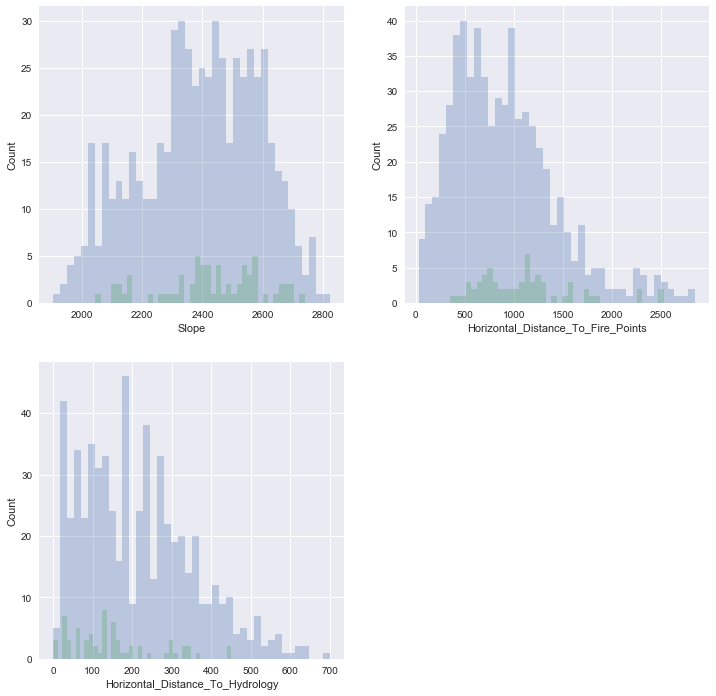

In [121]:
plt.figure(figsize=(12,12)) 

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
print("Median slope: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Slope), np.median(X_errors.Slope), (np.median(X_errors.Slope)/ np.median(X_true.Slope) * 100)))
print("Median distance to fire: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Fire_Points), np.median(X_errors.Horizontal_Distance_To_Fire_Points), (np.median(X_errors.Horizontal_Distance_To_Fire_Points) / np.median(X_true.Horizontal_Distance_To_Fire_Points) * 100)))
print("Median horizontal_hydro: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Hydrology), np.median(X_errors.Horizontal_Distance_To_Hydrology), (np.median(X_errors.Horizontal_Distance_To_Hydrology)/ np.median(X_true.Horizontal_Distance_To_Hydrology) * 100)))

plt.subplot(221)
plt.hist(X_true.Elevation, **kwargs)
plt.hist(X_errors.Elevation, **kwargs);
plt.xlabel("Slope") 
plt.ylabel("Count")

plt.subplot(222)
plt.hist(X_true.Horizontal_Distance_To_Fire_Points, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Fire_Points, **kwargs);
plt.xlabel("Horizontal_Distance_To_Fire_Points") 
plt.ylabel("Count")

plt.subplot(223)
plt.hist(X_true.Horizontal_Distance_To_Hydrology, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Hydrology, **kwargs);
plt.xlabel("Horizontal_Distance_To_Hydrology") 
plt.ylabel("Count")
plt.show()

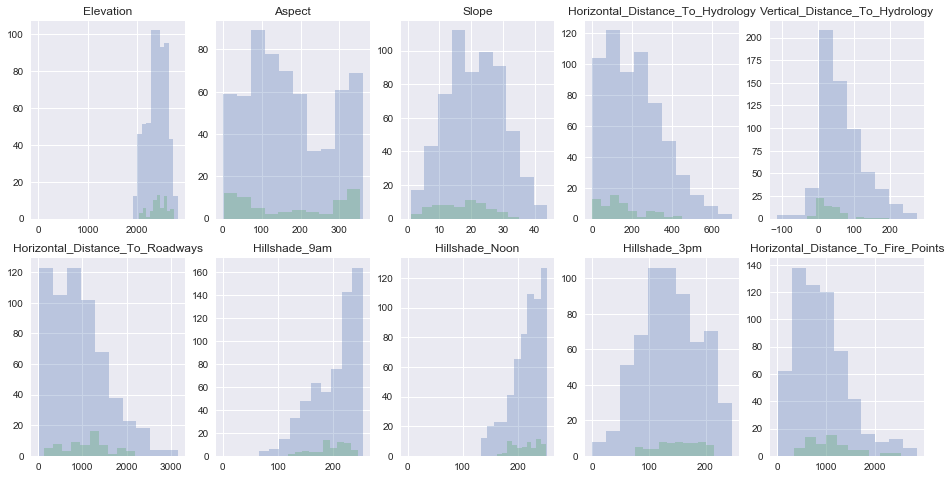

In [122]:
#Display the data between classes 3 and 6
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in [3, 6]:
        axi.hist(X_true.ix[labels==label, i], **kwargs)
        axi.hist(X_errors.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

This error certainly seems to have more noticeable differences between the correctly chosen answers and the wrong ones; however with such a relatively small group of errors, it's hard to make any conclusive statements about it.

# Test results

In [182]:
test_df = pd.read_csv("../data/test.csv")
print(test_df.shape)
test_df.head()

(565892, 55)


Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            196             214            156   
1            201             216            152   
2            206             208            137   
3            208             201            125   
4            210             195            115   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6645                 1                 0   
1                                6675                 1                 0   
2                                6344                 1                 0   
3                                6374                 1                 0   
4                                6404                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0

In [188]:
# ### Add new features to test data and training data
new_train = get_new_features_data_rf(data)
new_test_df = get_new_features_data_rf(test_df)
new_test_df.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            196             214            156   
1            201             216            152   
2            206             208            137   
3            208             201            125   
4            210             195            115   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6645                 1                 0   
1                                6675                 1                 0   
2                                6344                 1                 0   
3                                6374                 1                 0   
4                                6404                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0

In [ ]:
rfc = best_rfc.get_params()['randomforestclassifier']
rfc.fit(new_train, labels)

new_test_df['Cover_Type'] = pd.Series(rfc.predict(new_test_df.drop(['Id'], axis=1)))

submission = pd.concat([new_test_df['Id'].astype(int), new_test_df['Cover_Type']], axis=1)
submission = submission.set_index('Id')
submission.to_csv('submission.csv')
submission.head()

Cover_Type
Id               
15121           1
15122           1
15123           1
15124           1
15125           1

Results from Kaggle: 0.80025

# Appendix
a. There being so many soil types, we thought that it might be advantageous to utilze PCA to reduce the variables needed.

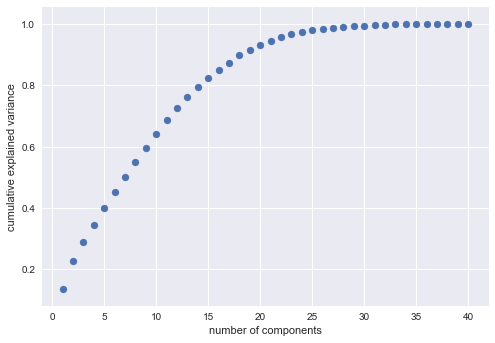

In [88]:
# Separate soil data from X_train

X_train_less_soil = X_train.drop([i for i in X_train.columns if "Soil_Type" in i],axis=1)
X_test_less_soil = X_test.drop([i for i in X_test.columns if "Soil_Type" in i],axis=1)

soil_train = X_train[[i for i in X_train.columns if "Soil_Type" in i]]
soil_test = X_test[[i for i in X_test.columns if "Soil_Type" in i]]

pca = PCA(n_components=40)
pca.fit(soil_train)
plt.scatter(range(1,41),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

**We see that with only 15 components that we preserve about 80% of the variation.**

In [89]:
# Fit PCA and transform train and test data
p = PCA(n_components=15)
pca_soil_train = p.fit_transform(soil_train)
pca_soil_test = p.transform(soil_test)

# Convert back to Dataframes
pca_soil_train = pd.DataFrame(pca_soil_train)
pca_soil_test = pd.DataFrame(pca_soil_test)

# Make sure they're still on same index
pca_soil_train.index = soil_train.index
pca_soil_test.index = soil_test.index

# Put data back together
soil_pca_X_train = pd.concat([X_train_less_soil,pca_soil_train],axis=1,join_axes=[X_train_less_soil.index])
soil_pca_X_test = pd.concat([X_test_less_soil,pca_soil_test],axis=1,join_axes=[X_test_less_soil.index])

RF = RandomForestClassifier()

RF.fit(X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(X_test, y_test)))

RF.fit(soil_pca_X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(soil_pca_X_test, y_test)))

The accuracy score before PCA reduction was: 0.8476953907815631
The accuracy score before PCA reduction was: 0.8585170340681363


## Features that didn't work

Features that we thought would be helpful to engineer.  However, by engineering these features, we didn't see much improvement and therefore these were discarded in the final model.

### Binning hillshade_9am

In [108]:
def bin_hillshade_9am_feat(data):
    new_data = data.copy(deep=True)

    noon_bins = np.linspace(0, 255, 8)
    which_bin = np.digitize(new_data.Hillshade_9am, bins=noon_bins)
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(which_bin.reshape(-1, 1))
    X_noon_binned = pd.DataFrame(encoder.transform(which_bin.reshape(-1, 1)))

    new_data = pd.concat([new_data, X_noon_binned], axis=1)

    return new_data

In [109]:
new_data = bin_hillshade_9am_feat(data)
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8244
Base LR:  0.6772, New LR:  0.6772


### Euclidean Distance to Hydrology

In [147]:
def new_euclidean_hydro(data):
    new_data = data.copy(deep=True)
    new_feature = (new_data.Horizontal_Distance_To_Hydrology**2 + new_data.Vertical_Distance_To_Hydrology**2) ** (1/2)
    new_data['new_euclidean_hydro'] = new_feature
    return new_data

new_data = new_euclidean_hydro(data)
print_base_results(new_data)

Base RFC: 0.8224, New RFC: 0.8188
Base LR:  0.6772, New LR:  0.6770


### Slope using Elevation and Hydrology

In [ ]:
#Adjusting distance to hydrology and roadways 
slope_train = pd.DataFrame()
slope_test = pd.DataFrame()

#Elevation adjusted by Horizontal distance to Hyrdrology 
slope_train['slope_hyd'] = np.sqrt(X_train.Vertical_Distance_To_Hydrology**2 + X_train.Horizontal_Distance_To_Hydrology**2) 
slope_train.slope_hyd=slope_train.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_train['slope_hyd_pct'] = X_train.Vertical_Distance_To_Hydrology / X_train.Horizontal_Distance_To_Hydrology
slope_train.slope_hyd_pct=slope_train.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_test['slope_hyd'] = np.sqrt(X_test.Vertical_Distance_To_Hydrology**2 + X_test.Horizontal_Distance_To_Hydrology**2) 
slope_test.slope_hyd=slope_test.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_test['slope_hyd_pct'] = X_test.Vertical_Distance_To_Hydrology / X_test.Horizontal_Distance_To_Hydrology
slope_test.slope_hyd_pct=slope_test.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_train.index = X_train.index
slope_test.index = X_test.index

X_train_slope = pd.concat([X_train,slope_train], axis =1, join_axes=[X_train.index])
X_test_slope = pd.concat([X_test,slope_test], axis=1, join_axes=[X_test.index])

# Test on a model

without_slope = []
with_slope = []
for i in range(10):
    log = RandomForestClassifier()
    log.fit(X_train, y_train)
    without_slope.append(log.score(X_test, y_test))

    log.fit(X_train_slope, y_train)
    with_slope.append(log.score(X_test_slope, y_test))
print ("Accuracy without extra slope feature is {}".format(np.mean(without_slope)))
print ("Accuracy with extra slope feature is {}".format(np.mean(with_slope)))

### Convert aspect to cardinal direction (north, south, east, west)

In [110]:
def convert_to_cardinal_feat(data):
    new_data = data.copy(deep=True)
    dir_labels = ['north east', 'east north', 'east south', 'south east', 
              'south west', 'west south', 'west north', 'north west']
    new_data.loc[:, ('direction')] = pd.cut(data.loc[:, ('Aspect')], range(0, 365, 45), right=False, labels=dir_labels)

    new_data.direction = new_data.direction.replace('east north', 'north') \
        .replace('north west', 'north') \
        .replace('east north', 'east').replace('east south', 'east').replace('south east', 'south') \
        .replace('south west', 'south').replace('west south', 'west').replace('west north', 'west') \
        .replace('north east', 'north')

    new_data = pd.get_dummies(new_data)
    return new_data

In [111]:
new_data = convert_to_cardinal_feat(data)
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8108
Base LR:  0.6772, New LR:  0.6794
